<a href="https://colab.research.google.com/github/MaliheDahmardeh/state-house-price-analysis-SM/blob/main/state-house-price-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Brief description of the dataset
This dataset provides information about the mean home prices across a number of US states and housing types
collected in the period from 30th April 1996 to 31st December 2017 (monthly data). The data are available for 44
states and different house types, in particular 1/2/3/4/5+ bedrooms and single family residence.
#Project steps
The main aim of this project is to perform house price forecasting for the last two years (2016/2017), whose data
should be used as testing set.
Following what we have seen in the laboratory classes, a comprehensive pipeline should be devised, including in
particular:
1. Loading, converting and cleaning of the data;
2. Exploring the dataset with descriptive statistics and (possibly) frequency analysis. Use appropriate graphs to
visualise the data at hand;
3. Focusing on few US states and housing types, describing the time series patterns (visually and numerically);
4. Choosing the appropriate model/models to forecast the data for the specified period for each selected
state/house type. Evaluate the model performance using different metrics. Visualise the results with
appropriate graphs.


#Import

In [247]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil import parser
import math
import statistics
from statistics import median
from fractions import Fraction as fr
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import plotly.express as px
from scipy import stats,signal
from scipy.stats import chi2, chi2_contingency
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Dataset Loading ...

In [248]:
!ls

sample_data  State_house_prices_ts.csv


In [249]:
df = pd.read_csv('State_house_prices_ts.csv', sep =',',parse_dates=['Date']).sort_values(by='Date', ascending=True , inplace=False)

In [250]:
display(df)
display(type(df))
display(df.dtypes)

,Date,RegionName,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
1997,1996-04-30,Illinois,83800.0,92000.0,109300.0,171700.0,224000.0,116000.0
2006,1996-04-30,Michigan,66600.0,76900.0,98200.0,170200.0,166500.0,85400.0
2005,1996-04-30,Massachusetts,82900.0,106600.0,136300.0,195400.0,249200.0,144300.0
2003,1996-04-30,Maine,NaN,79000.0,91500.0,112600.0,135100.0,88300.0
2002,1996-04-30,Louisiana,NaN,NaN,76400.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
12988,2017-12-31,Maryland,160400.0,193400.0,251300.0,378700.0,507700.0,285000.0
12989,2017-12-31,Massachusetts,289300.0,301000.0,368300.0,519100.0,720900.0,392900.0
12990,2017-12-31,Michigan,101700.0,118800.0,158500.0,282900.0,294100.0,134800.0
12992,2017-12-31,Mississippi,NaN,NaN,124100.0,221000.0,250400.0,118500.0


pandas.core.frame.DataFrame

Date                           datetime64[ns]
RegionName                             object
Price_1bedroom                        float64
Price_2bedroom                        float64
Price_3bedroom                        float64
Price_4bedroom                        float64
Price_5BedroomOrMore                  float64
Price_SingleFamilyResidence           float64
dtype: object

In [251]:
print('columns:', df.columns)
print('')
print('indexes:', df.index)
print('')
print('values:', df.values)

columns: Index(['Date', 'RegionName', 'Price_1bedroom', 'Price_2bedroom',
       'Price_3bedroom', 'Price_4bedroom', 'Price_5BedroomOrMore',
       'Price_SingleFamilyResidence'],
      dtype='object')

indexes: Int64Index([ 1997,  2006,  2005,  2003,  2002,  2001,  2000,  1999,  1998,
             1996,
            ...
            12983, 12984, 12985, 12986, 12987, 12988, 12989, 12990, 12992,
            13006],
           dtype='int64', length=13212)

values: [[Timestamp('1996-04-30 00:00:00') 'Illinois' 83800.0 ... 171700.0
  224000.0 116000.0]
 [Timestamp('1996-04-30 00:00:00') 'Michigan' 66600.0 ... 170200.0
  166500.0 85400.0]
 [Timestamp('1996-04-30 00:00:00') 'Massachusetts' 82900.0 ... 195400.0
  249200.0 144300.0]
 ...
 [Timestamp('2017-12-31 00:00:00') 'Michigan' 101700.0 ... 282900.0
  294100.0 134800.0]
 [Timestamp('2017-12-31 00:00:00') 'Mississippi' nan ... 221000.0
  250400.0 118500.0]
 [Timestamp('2017-12-31 00:00:00') 'Pennsylvania' 118800.0 ... 292100.0
  307000.0 16

In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13212 entries, 1997 to 13006
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         13212 non-null  datetime64[ns]
 1   RegionName                   13212 non-null  object        
 2   Price_1bedroom               10605 non-null  float64       
 3   Price_2bedroom               11745 non-null  float64       
 4   Price_3bedroom               12787 non-null  float64       
 5   Price_4bedroom               12359 non-null  float64       
 6   Price_5BedroomOrMore         11814 non-null  float64       
 7   Price_SingleFamilyResidence  12438 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 929.0+ KB


#Data Cleaning

In [253]:
df.duplicated().sum()  

0

In [254]:
df.isnull().sum()

Date                              0
RegionName                        0
Price_1bedroom                 2607
Price_2bedroom                 1467
Price_3bedroom                  425
Price_4bedroom                  853
Price_5BedroomOrMore           1398
Price_SingleFamilyResidence     774
dtype: int64

In [255]:
#check the states that have empty/null row 
a=df.loc[df.isnull().sum(axis=1) > 5]
a.groupby('RegionName').nunique()

,Date,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
RegionName,,,,,,,
Alaska,10,0,0,0,0,0,0
DistrictofColumbia,10,0,0,0,0,0,0
Kansas,64,0,0,0,0,0,0
UnitedStates,95,0,0,0,0,0,0


In [256]:
# drop the states that have lots of null value 
df=df[(df.RegionName != 'UnitedStates')]
df=df[(df.RegionName != 'Kansas')]
df=df[(df.RegionName != 'NewYork')]
df=df[(df.RegionName != 'Wyoming')]
df=df[(df.RegionName != 'NorthDakota')]
df=df[(df.RegionName != 'Texas')]
df=df[(df.RegionName != 'Louisiana')]
df=df[(df.RegionName != 'Utah')]
df=df[(df.RegionName != 'Vermont')]
df=df[(df.RegionName != 'WestVirginia')]
df=df[(df.RegionName != 'SouthCarolina')]
df=df[(df.RegionName != 'NewMexico')]
df=df[(df.RegionName != 'Mississippi')]
df=df[(df.RegionName != 'Nevada')]

In [257]:
df.isnull().sum()

Date                             0
RegionName                       0
Price_1bedroom                  90
Price_2bedroom                  20
Price_3bedroom                  36
Price_4bedroom                 100
Price_5BedroomOrMore           208
Price_SingleFamilyResidence     36
dtype: int64

In [258]:
rc=df.groupby('Date')['RegionName'].count()
rc

Date
1996-04-30    34
1996-05-31    35
1996-06-30    35
1996-07-31    35
1996-08-31    35
              ..
2017-08-31    38
2017-09-30    38
2017-10-31    38
2017-11-30    38
2017-12-31    38
Name: RegionName, Length: 261, dtype: int64

In [259]:
rm=df.groupby('RegionName').median()
#rm['Date'] = pd.to_datetime(rm['Date'])
#rm['Date']= rm['Date'].asfreq('M')
rm

,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
RegionName,,,,,,
Alabama,88100.0,69700.0,116800.0,218900.0,316200.0,115600.0
Alaska,124550.0,175550.0,251100.0,319600.0,416800.0,254300.0
Arizona,87100.0,133100.0,150800.0,203900.0,315600.0,165300.0
Arkansas,80200.0,81500.0,122500.0,212100.0,323900.0,102400.0
California,219500.0,273000.0,316100.0,415200.0,565900.0,344000.0
Colorado,134300.0,163600.0,210600.0,293000.0,361200.0,222300.0
Connecticut,118800.0,167600.0,231400.0,356200.0,570300.0,253800.0
Delaware,122400.0,144400.0,182600.0,284200.0,343600.0,190800.0
DistrictofColumbia,323200.0,386500.0,353500.0,567300.0,1123400.0,372900.0


In [260]:
#use median for other null values
num_cols = df.select_dtypes(exclude='object').columns
df[num_cols] = df.groupby(['RegionName'])[num_cols].apply(lambda x:x.fillna(x.median()))

display(df)
display(type(df))
display(df.dtypes)

,Date,RegionName,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
1997,1996-04-30,Illinois,83800.0,92000.0,109300.0,171700.0,224000.0,116000.0
2006,1996-04-30,Michigan,66600.0,76900.0,98200.0,170200.0,166500.0,85400.0
2005,1996-04-30,Massachusetts,82900.0,106600.0,136300.0,195400.0,249200.0,144300.0
2003,1996-04-30,Maine,156000.0,79000.0,91500.0,112600.0,135100.0,88300.0
2001,1996-04-30,Kentucky,49300.0,64600.0,78600.0,126800.0,151100.0,74400.0
...,...,...,...,...,...,...,...,...
12987,2017-12-31,Maine,180000.0,206500.0,240300.0,298800.0,372400.0,215500.0
12988,2017-12-31,Maryland,160400.0,193400.0,251300.0,378700.0,507700.0,285000.0
12989,2017-12-31,Massachusetts,289300.0,301000.0,368300.0,519100.0,720900.0,392900.0
12990,2017-12-31,Michigan,101700.0,118800.0,158500.0,282900.0,294100.0,134800.0


pandas.core.frame.DataFrame

Date                           datetime64[ns]
RegionName                             object
Price_1bedroom                        float64
Price_2bedroom                        float64
Price_3bedroom                        float64
Price_4bedroom                        float64
Price_5BedroomOrMore                  float64
Price_SingleFamilyResidence           float64
dtype: object

In [261]:
df.isnull().sum()

Date                           0
RegionName                     0
Price_1bedroom                 0
Price_2bedroom                 0
Price_3bedroom                 0
Price_4bedroom                 0
Price_5BedroomOrMore           0
Price_SingleFamilyResidence    0
dtype: int64

#Functions

In [262]:
def checkAutorcorrelation(resid, lags=36, return_data=False):
    import pandas as pd
    import statsmodels.formula.api as smf
    import statsmodels.api as sm
    import statsmodels.stats.diagnostic as dg
    
    #Ljung-Box
    lb_result = sm.stats.acorr_ljungbox(resid, lags=[lags], return_df=False)
    print("*** Ljung-Box Test [{} lags] ***".format(lags))
    print('Q: ', lb_result[0][0])
    print('p-value: ' , lb_result[1][0])
    if lb_result[1][0]>.05:
        print('Interpretation: the residuals are independently distributed (Ho)')
    else:
        print('Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)')
    
    #Breusch-Godfrey
    resid = pd.DataFrame(resid, columns=['resid'])
    resid['step'] = range(len(resid))
    fit = smf.ols('resid ~ step', data=resid).fit()
    bg_result = dg.acorr_breusch_godfrey(fit, nlags=lags)
    print('\n*** Breusch-Godfrey Test [{} lags] ***'.format(lags))
    print('Lagrange multiplier statistic: ', bg_result[0])
    print('p-value: ', bg_result[1])
    if bg_result[1]>.05:
        print('Interpretation: there is no autocorrelation at any order less than or equal to p (Ho)')
    else:
        print('Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)')
    
    if return_data==True:
        return (lb_result[0][0], lb_result[1][0], bg_result[0], bg_result[1])

In [263]:
def checkNormality(data, return_data=False):
    from scipy.stats import shapiro, jarque_bera, normaltest, skew, kurtosis
    
    #Shapiro-Wilk
    w, p_w = shapiro(data)
    print('*** Shapiro-Wilk Test ***')
    print('W: ', w)
    print('p-value: ' , p_w)
    if p_w > .05:
        print('Interpretation: the data was drawn from a normal distribution (Ho)')
    else:
        print('Interpretation: the data was not drawn from a normal distribution (Ha)')
    
    #Jarque-Bera
    jb, p_jb = jarque_bera(data)
    print('\n*** Jarque-Bera Test ***')
    print('Jarque-Bera JB: ', jb)
    print('p-value: ' , p_jb)
    if p_jb > .05:
        print('Interpretation: the data was drawn from a normal distribution (Ho)')
    else:
        print('Interpretation: the data was not drawn from a normal distribution (Ha)')
    
    #D’Agostino-Pearson
    k2, p_k2 = normaltest(data)
    print("\n*** D’Agostino-Pearson Test ***")
    print('k2: ', k2)
    print('p-value: ' , p_k2)
    if p_k2 > .05:
        print('Interpretation: the data was drawn from a normal distribution (Ho)')
    else:
        print('Interpretation: the data was not drawn from a normal distribution (Ha)')

    print('\n----------------------------------------------------------------------')
    print('Skewness: ', skew(data))
    print('Kurtosis : ', kurtosis(data))
    
    if return_data==True:
        return (w, p_w, jb, p_jb, k2, p_k2)

In [264]:
def checkStationarity(data, kpss_type = 'ct', return_data=False, ci=.95):
    alpha = 1-ci
    
    if kpss_type in ['c','ct']:
        import warnings
        warnings.filterwarnings('ignore')
        from statsmodels.tsa.stattools import adfuller
        from statsmodels.tsa.stattools import kpss

        adf_test = adfuller(data,autolag='AIC')
        print('*** ADF Test ***')
        print('ADF Statistic: ', adf_test[0])
        print('p-value: ', adf_test[1])
        if adf_test[1] > alpha:
            print('Interpretation: The time series is non-stationary (Ho)')
        else:
            print('Interpretation: The time series is stationary (Ha)')

        kpss_test = kpss(data, regression=kpss_type, store=True)
        print('\n*** KPSS Test ***')
        print('KPSS Statistic:', kpss_test[0])
        print('p-value: ', kpss_test[1])

        if kpss_type == 'c':
            if kpss_test[1] > alpha:
                print('Interpretation: The time series is stationary (Ho)')
            else:
                print('Interpretation: The time series is not stationary (Ha)')
        if kpss_type == 'ct':
            if kpss_test[1] > alpha:
                print('Interpretation: The time series is trend stationary (Ho)')
            else:
                print('Interpretation: The time series is not trend stationary (Ha)')
    else:
        print('KPSS type shuld be c or ct!')
        print('c: checks if time series is stationary \nct: checks if time series is trend stationary')
    
    if return_data==True:
        return (adf_test[0],adf_test[1],kpss_test[0],kpss_test[1])

In [265]:
def autocorrelationPlot(data, lags=30, title=''):
    from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
    import matplotlib.pyplot as plt
    
    fig = plot_acf(data, lags=lags, title='Auto-correlation for the first {} lags {}'.format(lags, title));
    fig.set_figwidth(16)
    fig.set_figheight(6)
    fig = plot_pacf(data, lags=lags, title='Partial Auto-correlation for the first {} lags {}'.format(lags, title));
    fig.set_figwidth(16)
    fig.set_figheight(6)
    plt.show()

In [266]:
def scalelocationPlot(resid, title='', figsize=(16,8)):
    import pandas as pd
    import statsmodels.formula.api as smf
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    #lm
    resid = pd.DataFrame(resid, columns=['resid'])
    resid['step'] = range(len(resid))
    fit = smf.ols('resid ~ step', data=resid).fit()
    
    #get values
    model_fitted_y = fit.fittedvalues
    model_residuals = fit.resid
    model_norm_residuals = fit.get_influence().resid_studentized_internal
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    
    #plot
    fig = plt.figure(3)
    fig.set_figheight(figsize[1])
    fig.set_figwidth(figsize[0])
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, scatter=False, ci=False, lowess=True,line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})
    fig.axes[0].set_title('Scale-Location'.format(title), fontsize=14)
    fig.axes[0].set_xlabel('Fitted values')
    fig.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$')
    plt.show()

In [267]:
def plotTS(df, column, loess=True, regression=True, figsize=(16,4), title='', xlabel='', ylabel='', theme = 'darkgrid', points_alpha = 0.6, custom_ylim=None):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    from statsmodels.nonparametric.smoothers_lowess import lowess


    sns.set_style(theme)
    plt.figure(figsize=figsize)
    plt.scatter(x = df.index, y = df[column], marker='+', alpha=points_alpha, label='Data points')
    
    if loess==True:
        # model fitting
        span, sse = compute_loess_span(df.index,df[column])
        y_loess = lowess(df[column], df.index,  frac=span, it=5, return_sorted = False).T
        #plot
        plt.plot(df.index, y_loess, color='tomato', linewidth=2, label='LOESS (span={})'.format(span))
    if regression==True:
        # model fitting
        model = LinearRegression()
        x_regr = np.arange(len(df[column])).reshape(-1,1)
        model.fit(x_regr,df[column])
        coeff = model.coef_[0]
        y_predicted = model.predict(x_regr)
        #plot
        plt.plot(df.index, y_predicted, color='green', label='Regression line (coeff={})'.format(round(coeff,2)))

    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [268]:
def qqPlot(data, title=''):
    fig = sm.qqplot(data, line ='45',fit=True,dist=stats.norm)
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.title('Q-Q {}'.format(title))
    plt.show()

In [269]:
def compute_loess_span(x_input,y_input, steps=0.02):
    import numpy as np
    from statsmodels.nonparametric.smoothers_lowess import lowess

    best_span = 0.51
    lowest_SSE = 10e20
    
    for i in np.arange(1,51,steps*100)/100:
        span=i
        y_pred = lowess(y_input,x_input, frac=span, it=5, return_sorted = False).T
        SSE = ((y_input-y_pred)**2).sum()
        if SSE<lowest_SSE:
            best_span = i
            lowest_SSE = SSE
    return (best_span,lowest_SSE)

In [270]:
def checkHomoscedasticity(resid, return_data=False, robust=False, includeWhite=False):
    import pandas as pd
    import statsmodels.formula.api as smf
    from statsmodels.compat import lzip
    import statsmodels.stats.api as sms
    from statsmodels.stats.diagnostic import het_white
    
    resid = pd.DataFrame(resid, columns=['resid'])
    resid['step'] = range(len(resid))
    fit = smf.ols('resid ~ step', data=resid).fit()
    
    if robust==False:
        #Bresuch-Pagan test
        lagrange_mult_statistic, p_value_bp, f_value, f_p_value = sms.het_breuschpagan(fit.resid, fit.model.exog, robust=False)
        print('*** Breusch-Pagan Test ***')
        print('Lagrange multiplier statistic: ', lagrange_mult_statistic)
        print('p-value: ', p_value_bp)
        if p_value_bp > .05:
            print('Interpretation: Homoscedasticity is present, the residuals are distributed with equal variance (Ho)')
        else:
            print('Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)')
    else:
        #Koenker test
        lagrange_mult_statistic, p_value_bp, f_value, f_p_value = sms.het_breuschpagan(fit.resid, fit.model.exog , robust=True)
        print('*** Koenker Test ***')
        print('Lagrange multiplier statistic: ', lagrange_mult_statistic)
        print('p-value: ', p_value_bp)
        if p_value_bp > .05:
            print('Interpretation: Homoscedasticity is present, the residuals are distributed with equal variance (Ho)')
        else:
            print('Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)')

    if includeWhite == True:    
        #White's test
        test_stat, p_value_w, f_stat, f_p_value = het_white(fit.resid,  fit.model.exog)
        print("\n*** White's test ***")
        print('Test statistic: ', test_stat)
        print('p-value: ', p_value_w)
        if p_value_w >.05:
            print('Interpretation: Homoscedasticity is present, residuals are equally scattered (Ho)')
        else:
            print('Interpretation: Heteroscedasticity is present, residuals are not equally scattered (Ha)')
        if return_data==True:
            return (lagrange_mult_statistic,p_value_bp,test_stat, p_value_w)
    else:
        if return_data==True:
            return (lagrange_mult_statistic,p_value_bp)

#Data manipulation

In [271]:
#name and number of states in the data set 
print('Total number of States :',df['RegionName'].nunique())
print('-------------')
print('Name of the States :',df['RegionName'].unique(),sep='\n')

Total number of States : 38
-------------
Name of the States :
['Illinois' 'Michigan' 'Massachusetts' 'Maine' 'Kentucky' 'Iowa' 'Indiana'
 'Idaho' 'Hawaii' 'Georgia' 'Florida' 'Delaware' 'Connecticut' 'Colorado'
 'California' 'Arkansas' 'Arizona' 'Alabama' 'Minnesota' 'Maryland'
 'Nebraska' 'Wisconsin' 'Washington' 'Virginia' 'Missouri' 'RhodeIsland'
 'Pennsylvania' 'Tennessee' 'Oklahoma' 'Ohio' 'NorthCarolina' 'NewJersey'
 'NewHampshire' 'Oregon' 'SouthDakota' 'Alaska' 'Montana'
 'DistrictofColumbia']


In [272]:
df.describe()

,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
count,9851.000000,9851.000000,9851.000000,9851.000000,9.851000e+03,9851.000000
mean,118055.750685,137640.462897,176001.167394,255885.544615,3.370980e+05,180735.651203
std,62512.800490,77300.766005,86017.737255,113083.125026,1.813825e+05,98442.834585
min,30900.000000,32800.000000,59400.000000,79900.000000,1.076000e+05,56300.000000
25%,74900.000000,85500.000000,119800.000000,179500.000000,2.186000e+05,116000.000000
50%,100800.000000,114500.000000,146100.000000,225400.000000,2.945000e+05,148900.000000
75%,141650.000000,169350.000000,214450.000000,301600.000000,3.833000e+05,221200.000000
max,390200.000000,542400.000000,639700.000000,850400.000000,1.497000e+06,737500.000000


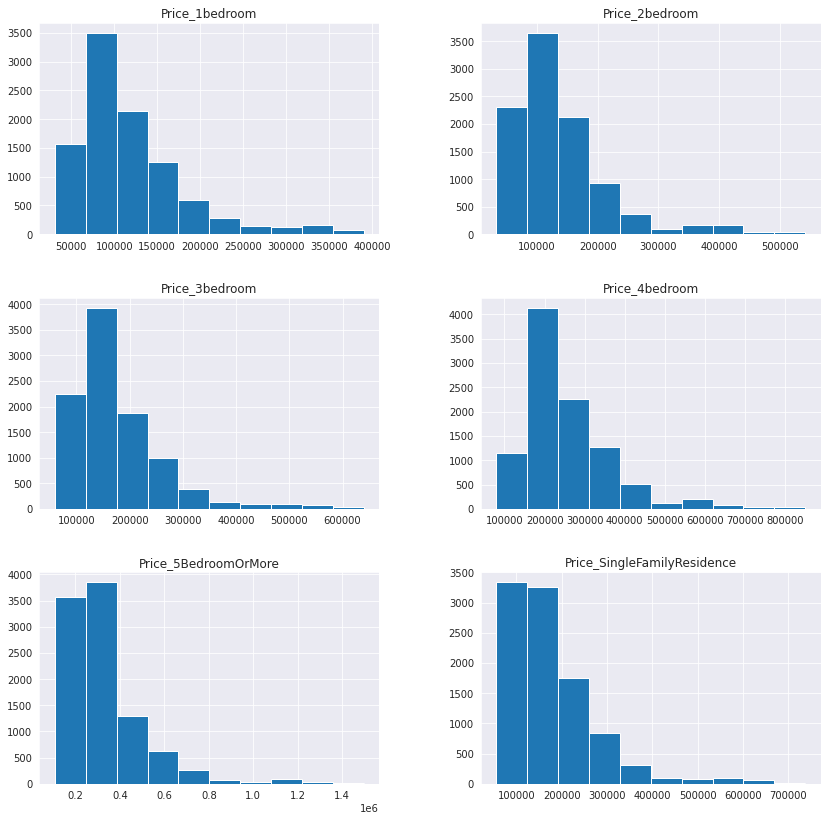

In [273]:
#histogram for different type of houses
df_hist = df.drop(columns=['Date'],axis=1)
df_hist.hist(figsize=(14,14));

In [274]:
#creat a pivot table of states regarding the date and total price of all type of houses
df['houseprice']=df['Price_1bedroom']+df['Price_2bedroom']+df['Price_3bedroom']+df['Price_4bedroom']+df['Price_5BedroomOrMore']+df['Price_SingleFamilyResidence']
house_price_by_region= pd.pivot_table(data=df, index='Date', columns='RegionName',values='houseprice')

In [275]:
display(house_price_by_region)
display(type(house_price_by_region))
display(house_price_by_region.dtypes)
display(house_price_by_region.index)

RegionName,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,DistrictofColumbia,Florida,...,Ohio,Oklahoma,Oregon,Pennsylvania,RhodeIsland,SouthDakota,Tennessee,Virginia,Washington,Wisconsin
Date,,,,,,,,,,,,,,,,,,,,,
1996-04-30,620400.0,NaN,668100.0,569900.0,991400.0,826900.0,927700.0,723100.0,NaN,625500.0,...,589100.0,418400.0,773600.0,604800.0,758500.0,NaN,593200.0,766000.0,837300.0,847200.0
1996-05-31,614900.0,NaN,668100.0,570700.0,988900.0,828800.0,926000.0,724200.0,NaN,626400.0,...,590100.0,418000.0,776500.0,603900.0,755900.0,524300.0,595100.0,766400.0,837200.0,846600.0
1996-06-30,613100.0,NaN,669200.0,572600.0,984400.0,829600.0,926300.0,725800.0,NaN,625600.0,...,590500.0,416900.0,779400.0,603300.0,753000.0,522200.0,597400.0,765600.0,836900.0,845600.0
1996-07-31,612600.0,NaN,670000.0,572900.0,980700.0,830400.0,927200.0,726400.0,NaN,624300.0,...,591700.0,416300.0,782400.0,602300.0,749500.0,520000.0,599400.0,764500.0,837100.0,844500.0
1996-08-31,611800.0,NaN,670900.0,573100.0,977800.0,831300.0,926400.0,726800.0,NaN,623800.0,...,592700.0,416200.0,785400.0,602000.0,746200.0,519600.0,601600.0,764100.0,837400.0,844000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,1007300.0,1704700.0,1446500.0,1050700.0,3170600.0,2119200.0,1725200.0,1436800.0,4395600.0,1482200.0,...,871900.0,837800.0,1995800.0,1162400.0,1778600.0,1091100.0,1203700.0,1723900.0,2240900.0,1053200.0
2017-09-30,1011800.0,1705200.0,1455300.0,1055200.0,3188700.0,2129000.0,1731800.0,1443700.0,4399600.0,1490900.0,...,876500.0,839800.0,2005500.0,1167900.0,1792400.0,1098300.0,1211500.0,1728900.0,2259300.0,1058900.0
2017-10-31,1013700.0,1707600.0,1465100.0,1059300.0,3209600.0,2139900.0,1736500.0,1455900.0,4398100.0,1499300.0,...,880900.0,841700.0,2012300.0,1173500.0,1807000.0,1103900.0,1218800.0,1732100.0,2278900.0,1063400.0


pandas.core.frame.DataFrame

RegionName
Alabama               float64
Alaska                float64
Arizona               float64
Arkansas              float64
California            float64
Colorado              float64
Connecticut           float64
Delaware              float64
DistrictofColumbia    float64
Florida               float64
Georgia               float64
Hawaii                float64
Idaho                 float64
Illinois              float64
Indiana               float64
Iowa                  float64
Kentucky              float64
Maine                 float64
Maryland              float64
Massachusetts         float64
Michigan              float64
Minnesota             float64
Missouri              float64
Montana               float64
Nebraska              float64
NewHampshire          float64
NewJersey             float64
NorthCarolina         float64
Ohio                  float64
Oklahoma              float64
Oregon                float64
Pennsylvania          float64
RhodeIsland           float64

DatetimeIndex(['1996-04-30', '1996-05-31', '1996-06-30', '1996-07-31',
               '1996-08-31', '1996-09-30', '1996-10-31', '1996-11-30',
               '1996-12-31', '1997-01-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=261, freq=None)

In [276]:
#looking for null value in the table,we drop some states that had lots of null values before
house_price_by_region.isnull().sum()

RegionName
Alabama                0
Alaska                17
Arizona                0
Arkansas               0
California             0
Colorado               0
Connecticut            0
Delaware               0
DistrictofColumbia    28
Florida                0
Georgia                0
Hawaii                 0
Idaho                  0
Illinois               0
Indiana                0
Iowa                   0
Kentucky               0
Maine                  0
Maryland               0
Massachusetts          0
Michigan               0
Minnesota              0
Missouri               0
Montana               21
Nebraska               0
NewHampshire           0
NewJersey              0
NorthCarolina          0
Ohio                   0
Oklahoma               0
Oregon                 0
Pennsylvania           0
RhodeIsland            0
SouthDakota            1
Tennessee              0
Virginia               0
Washington             0
Wisconsin              0
dtype: int64

In [277]:
#filling two null values with the value of their previous month
house_price_by_region = house_price_by_region.fillna(method='bfill')


In [278]:
# Converting the index as date with monthly frequency
house_price_by_region.index = pd.to_datetime(house_price_by_region.index)
house_price_by_region= house_price_by_region.asfreq('M')
display(house_price_by_region.index)

DatetimeIndex(['1996-04-30', '1996-05-31', '1996-06-30', '1996-07-31',
               '1996-08-31', '1996-09-30', '1996-10-31', '1996-11-30',
               '1996-12-31', '1997-01-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=261, freq='M')

#Data exploration

#How is the trend of the price of houses in the united states during the years:

In [279]:
#calculate total price in all states for every year(million dollar)
price_total = house_price_by_region.sum(axis=1)
price_total_by_year = price_total.resample('Y').sum()
price_total_by_year.index = price_total_by_year.index.year
price_total_by_year = price_total_by_year/1000000
display(price_total_by_year)

Date
1996    271.6830
1997    369.7065
1998    380.4314
1999    382.6119
2000    401.1767
2001    434.1992
2002    469.5015
2003    513.6184
2004    568.4394
2005    639.4013
2006    684.4801
2007    683.7260
2008    648.8314
2009    607.8839
2010    584.7957
2011    560.3810
2012    558.7941
2013    587.6207
2014    616.7675
2015    644.4621
2016    677.4210
2017    715.3453
dtype: float64

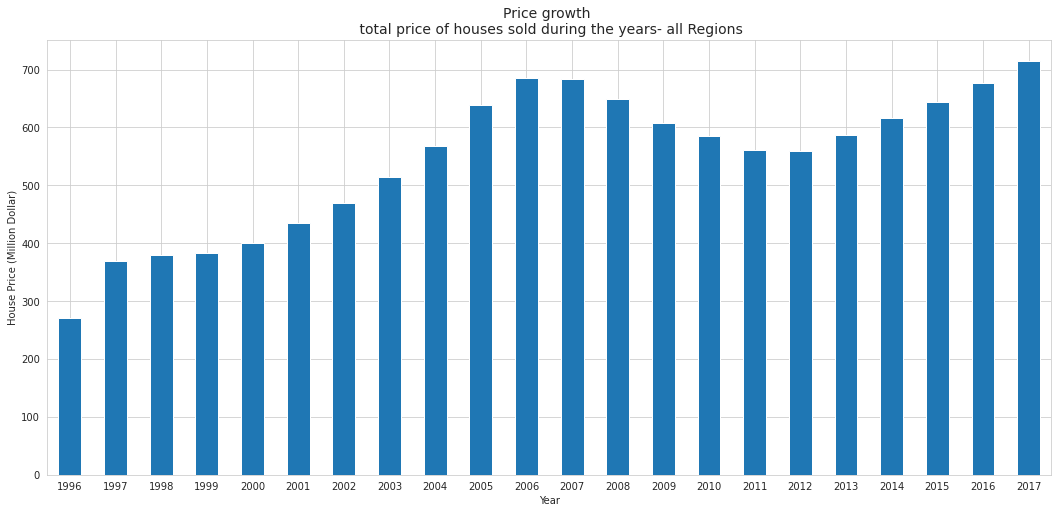

In [280]:
plt.figure(figsize=(18,8))
sns.set_style('whitegrid')
price_total_by_year.plot(kind='bar', rot=0, ylabel='House Price (Million Dollar)', xlabel='Year')
plt.title('Price growth \n total price of houses sold during the years- all Regions', fontsize=14)
plt.show()

#In what States the house price is higher and how is its trend

In [281]:
#finding the top 10 most expensive states
price_total_by_Region = house_price_by_region.sum(axis=0)
price_total_by_regions = pd.Series(price_total_by_Region , name='RegionName')
price_total_by_regions_top10 = price_total_by_Region.sort_values(ascending=False).head(10)
display(price_total_by_regions_top10)

RegionName
DistrictofColumbia    783773000.0
Hawaii                671738100.0
California            567633000.0
Massachusetts         493029300.0
NewJersey             431455000.0
Connecticut           418604300.0
Washington            385042700.0
Alaska                384497000.0
Maryland              382427500.0
RhodeIsland           372439900.0
dtype: float64

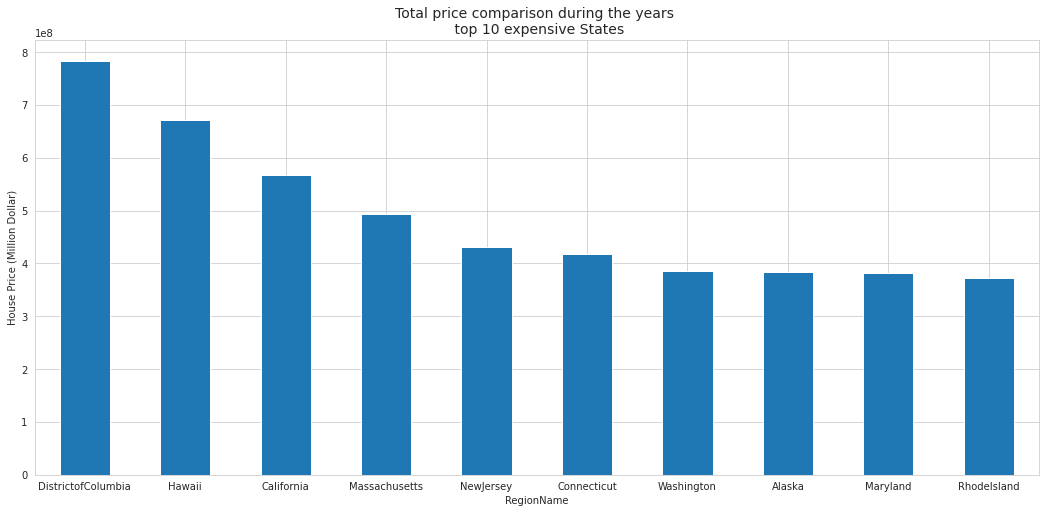

In [282]:
plt.figure(figsize=(18,8))
sns.set_style('whitegrid')
price_total_by_regions_top10.plot(kind='bar', rot=0, ylabel='House Price (Million Dollar)', xlabel='RegionName')
plt.title('Total price comparison during the years \n top 10 expensive States', fontsize=14)
plt.show()

#compare total price of houses in different states

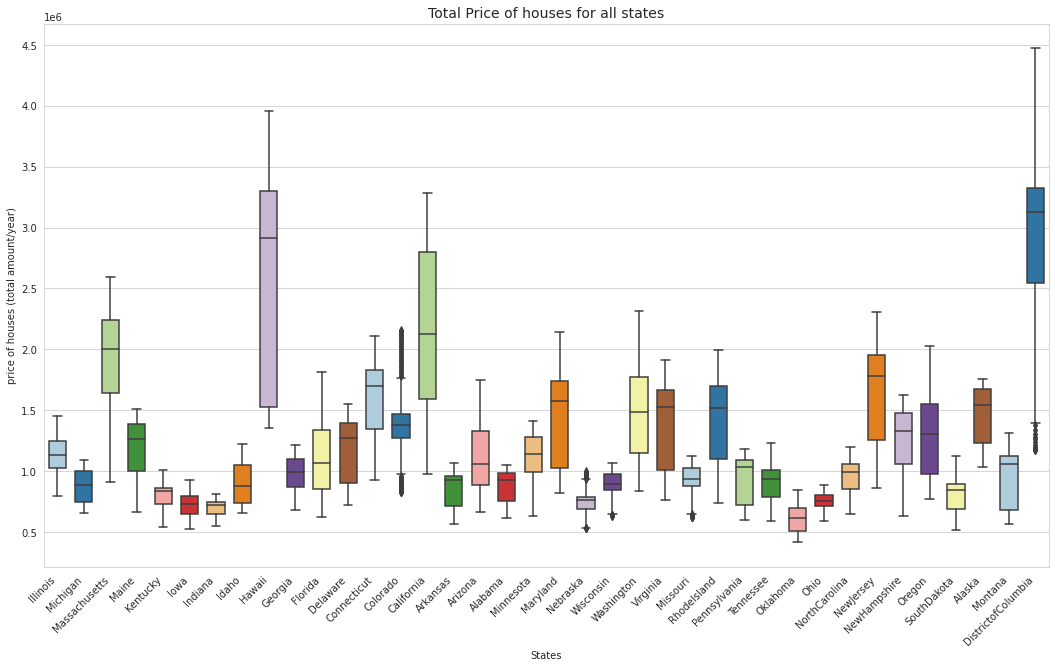

In [283]:
#check the total price of houses for all states
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(x="RegionName", y="houseprice", data=df, palette='Paired', width=0.65)
plt.title('Total Price of houses for all states', fontsize=14)
plt.xlabel('States')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.ylabel('price of houses (total amount/year)')
plt.show()

In [284]:
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
import plotly.graph_objs as go
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],[0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

# define our data for plotting
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = price_total_by_regions.index, # location (states)
        z = price_total_by_regions.values.astype(float), # Home value
        locationmode = 'USA-states', # let's define the location mode to USA_states
        text = 'house price in different states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "House value")
        ) ]

layout = dict(
        title = 'the value of all type of Houses in different states<br>',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
fig = dict( data=data, layout=layout )
# let's plot
iplot( fig, filename='d3-cloropleth-map' )

#How is the price in different months

In [285]:
#extract months and years of the date
price_groupby = df[['Date','RegionName','houseprice']].groupby(['Date','RegionName']).sum()
price_groupby['year'] = (price_groupby.index).to_series().map(lambda x : x[0].year)
price_groupby['month'] = (price_groupby.index).to_series().map(lambda x : x[0].month)
display(price_groupby)

houseprice  year  month
Date       RegionName                          
1996-04-30 Alabama        620400.0  1996      4
           Arizona        668100.0  1996      4
           Arkansas       569900.0  1996      4
           California     991400.0  1996      4
           Colorado       826900.0  1996      4
...                            ...   ...    ...
2017-12-31 SouthDakota   1123200.0  2017     12
           Tennessee     1232600.0  2017     12
           Virginia      1729000.0  2017     12
           Washington    2311900.0  2017     12
           Wisconsin     1069900.0  2017     12

[9851 rows x 3 columns]

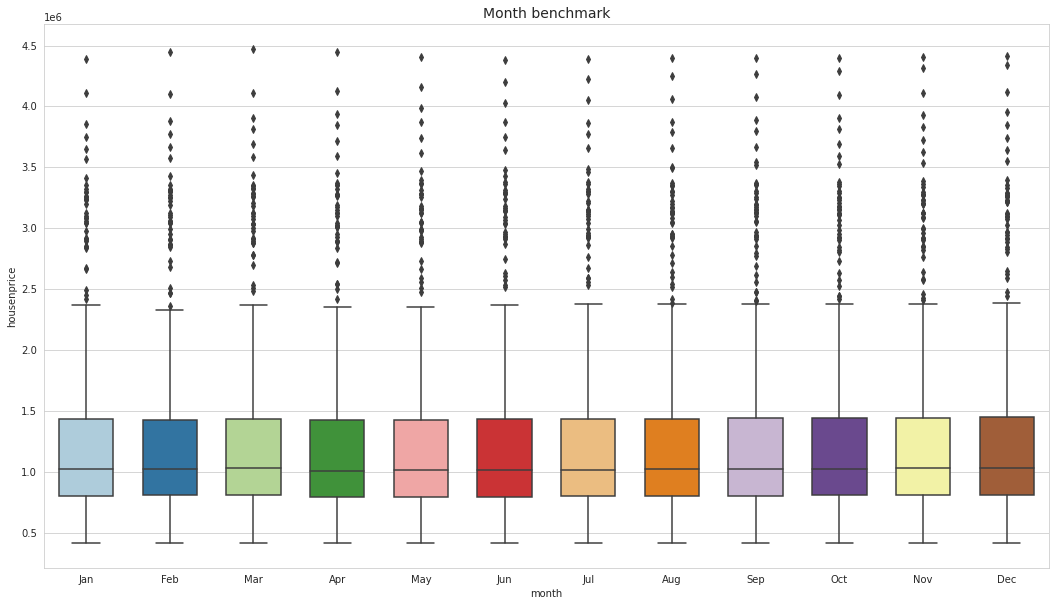

In [286]:
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(data=price_groupby, x='month', y='houseprice', palette='Paired', width=0.65)
plt.title('Month benchmark', fontsize=14)
plt.ylabel('housenprice')
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

#compare of price between different type of houses and how is the trend

In [287]:
#compare of price between different type of houses
d=df.groupby('Date').sum()[['Price_1bedroom','Price_2bedroom','Price_3bedroom','Price_4bedroom' ,'Price_5BedroomOrMore' ,'Price_SingleFamilyResidence']]
d.index = pd.to_datetime(d.index)
d= d.asfreq('M')
pr = d.resample('Y').sum()
pr.index = pr.index.year
pr.reset_index(level=0, inplace=True)

In [288]:
fig = px.line(pr,x='Date',y=['Price_1bedroom','Price_2bedroom','Price_3bedroom','Price_4bedroom' ,'Price_5BedroomOrMore' ,'Price_SingleFamilyResidence'])
fig.update_layout(title='<b>price growth of different type of Houses in USA<b> ',plot_bgcolor = 'whitesmoke')
fig.show()

#Discriptive Statistics-Time series Analysis

In [289]:
descriptive_stat = house_price_by_region.describe().T

Q1 = house_price_by_region.quantile(0.25)
Q3 = house_price_by_region.quantile(0.75)
IQR = Q3 - Q1

outlier_lower_count = (house_price_by_region < (Q1 - 1.5 * IQR)).sum()
outlier_upper_count = (house_price_by_region > (Q3 + 1.5 * IQR)).sum()
outlier_total_count = outlier_lower_count + outlier_upper_count

descriptive_stat['range']=descriptive_stat['max']-descriptive_stat['min']
descriptive_stat['IQR']=descriptive_stat['75%']-descriptive_stat['25%']
descriptive_stat['outlier_lower_count'] = outlier_lower_count
descriptive_stat['outlier_upper_count'] = outlier_upper_count
descriptive_stat['outlier_total_count'] = outlier_total_count

display(round(descriptive_stat,2))

,count,mean,std,min,25%,50%,75%,max,range,IQR,outlier_lower_count,outlier_upper_count,outlier_total_count
RegionName,,,,,,,,,,,,,
Alabama,261.0,875070.50,135617.28,611800.0,757600.0,926400.0,988400.0,1051900.0,440100.0,230800.0,0,0,0
Alaska,261.0,1473168.58,230561.18,1036800.0,1269600.0,1541900.0,1666800.0,1752900.0,716100.0,397200.0,0,0,0
Arizona,261.0,1116487.36,302705.38,668100.0,883700.0,1056600.0,1328800.0,1748900.0,1080800.0,445100.0,0,0,0
Arkansas,261.0,850105.36,145051.02,569900.0,714100.0,923700.0,963000.0,1063800.0,493900.0,248900.0,0,0,0
California,261.0,2174839.08,718250.34,976200.0,1593500.0,2130200.0,2801600.0,3280900.0,2304700.0,1208100.0,0,0,0
Colorado,261.0,1374563.60,301618.45,826900.0,1268400.0,1377000.0,1466700.0,2158900.0,1332000.0,198300.0,35,29,64
Connecticut,261.0,1603847.89,353687.60,924900.0,1343000.0,1699200.0,1834300.0,2106000.0,1181100.0,491300.0,0,0,0
Delaware,261.0,1181806.51,269770.23,723100.0,906200.0,1268900.0,1394200.0,1554000.0,830900.0,488000.0,0,0,0
DistrictofColumbia,261.0,3002961.69,814742.64,1174200.0,2855100.0,3126800.0,3303700.0,4472600.0,3298400.0,448600.0,47,32,79


In [290]:
Hawaii_ts = pd.DataFrame(house_price_by_region['Hawaii'])

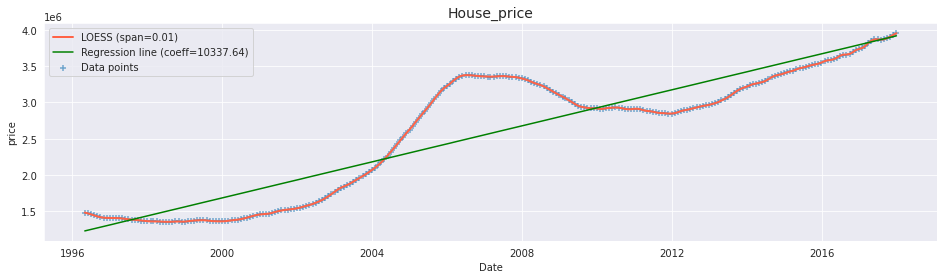

In [291]:
plotTS(Hawaii_ts, column='Hawaii',figsize=(16,4), title='House_price', xlabel='Date', ylabel='price')

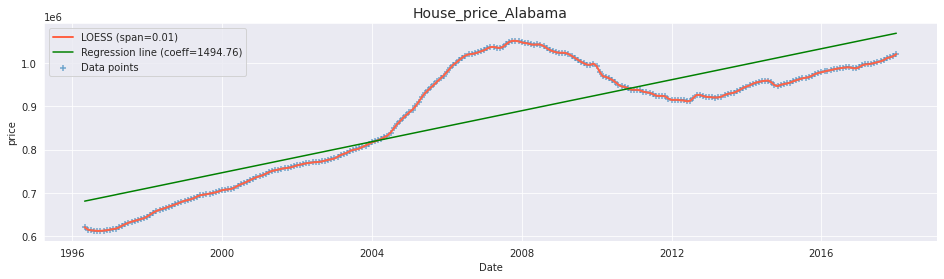

In [292]:
Alabama_ts = pd.DataFrame(house_price_by_region['Alabama'])
plotTS(Alabama_ts, column='Alabama', title='House_price_Alabama', xlabel='Date', ylabel='price')

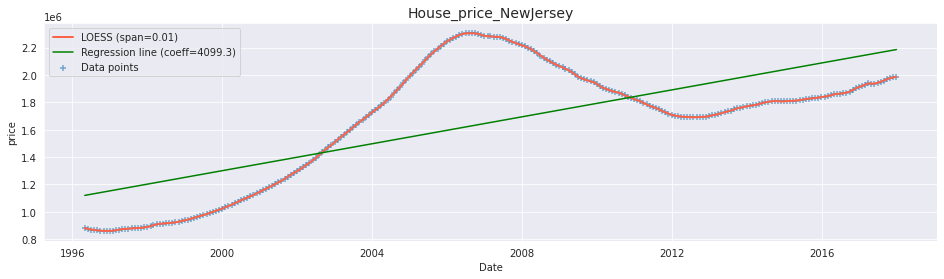

In [293]:
NewJersey_ts = pd.DataFrame(house_price_by_region['NewJersey'])
plotTS(NewJersey_ts, column='NewJersey', title='House_price_NewJersey', xlabel='Date', ylabel='price')

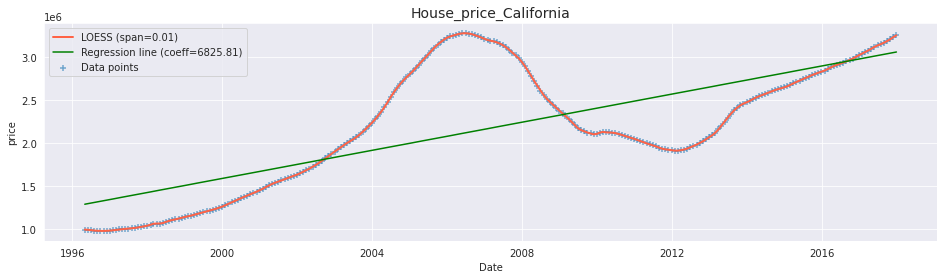

In [294]:
California_ts = pd.DataFrame(house_price_by_region['California'])
plotTS(California_ts, column='California', title='House_price_California', xlabel='Date', ylabel='price')

#Analysis of State,Hawaii

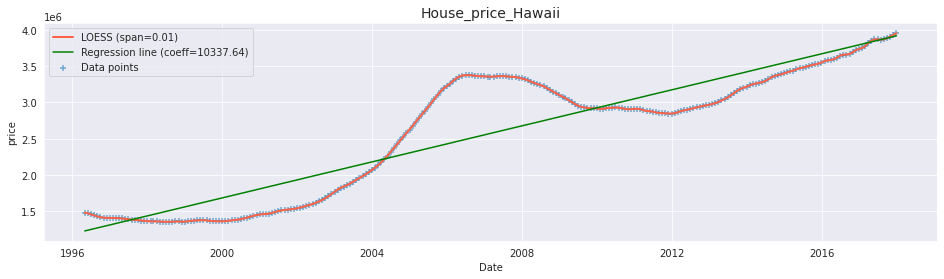

In [295]:
plotTS(Hawaii_ts, column='Hawaii',figsize=(16,4), title='House_price_Hawaii', xlabel='Date', ylabel='price')

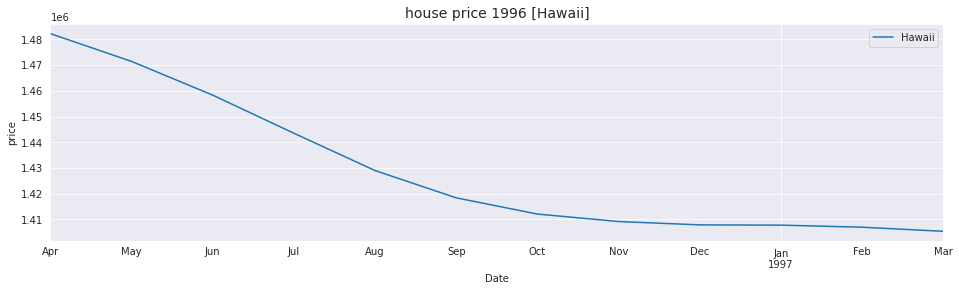

In [296]:
fig = Hawaii_ts[0:12].plot(figsize=(16,4), title='house price 1996 [Hawaii]')
fig.axes.title.set_size(14)
plt.xlabel('Date')
plt.ylabel('price')
plt.show()

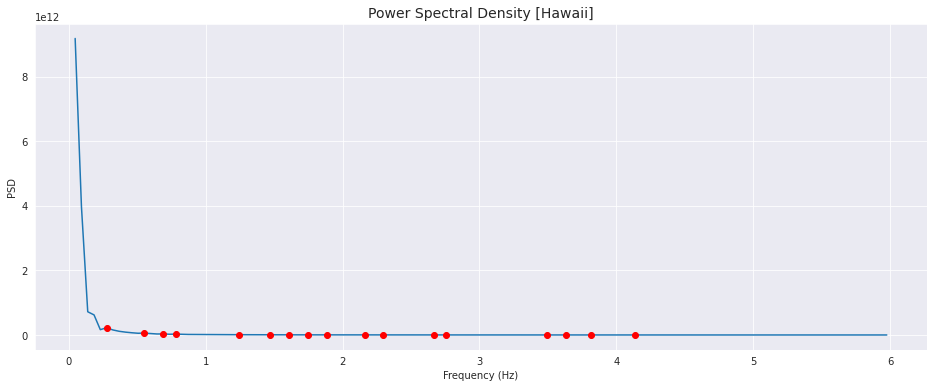

,Freq,Power,Period (year)
0,0.275862,2.250942e+11,3.625000
1,0.551724,5.849685e+10,1.812500
2,0.689655,3.267641e+10,1.450000
3,0.781609,2.767813e+10,1.279412
4,1.241379,9.576263e+09,0.805556
5,1.471264,7.253993e+09,0.679688
6,1.609195,6.373937e+09,0.621429
7,1.747126,5.408657e+09,0.572368
8,1.885057,4.791874e+09,0.530488
9,2.160920,3.927125e+09,0.462766


In [297]:
#check frequency 
Fs = 12  #per year-consider 12 months
f_per, Pxx_per = signal.periodogram(Hawaii_ts['Hawaii'],Fs,window=None,return_onesided=True,scaling='density')
sns.set_style('darkgrid')
plt.figure(figsize=(16,6))
plt.title('Power Spectral Density [Hawaii]', fontsize=14)
plt.plot(f_per[1:],Pxx_per[1:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')

f_per = f_per[1:]
Pxx_per = Pxx_per[1:]
peaks = signal.find_peaks(Pxx_per[ f_per >= 0], prominence=9000000)[0]
peaks_freq = f_per[peaks]
peaks_power = Pxx_per[peaks]
plt.plot(peaks_freq, peaks_power, 'ro')
plt.show()

data = {'Freq':peaks_freq, 'Power':peaks_power}
df_PSD = pd.DataFrame(data)
df_PSD['Period (year)'] = 1/df_PSD['Freq']
display(df_PSD)

#Stationarity

In [298]:
checkStationarity(Hawaii_ts['Hawaii'], kpss_type='c')

*** ADF Test ***
ADF Statistic:  -0.9812680163361206
p-value:  0.7600349062134676
Interpretation: The time series is non-stationary (Ho)

*** KPSS Test ***
KPSS Statistic: 1.3861937312012766
p-value:  0.01
Interpretation: The time series is not stationary (Ha)


In [299]:
checkStationarity(Hawaii_ts['Hawaii'], kpss_type='ct')

*** ADF Test ***
ADF Statistic:  -0.9812680163361206
p-value:  0.7600349062134676
Interpretation: The time series is non-stationary (Ho)

*** KPSS Test ***
KPSS Statistic: 0.19044060424763584
p-value:  0.019584773407136557
Interpretation: The time series is not trend stationary (Ha)


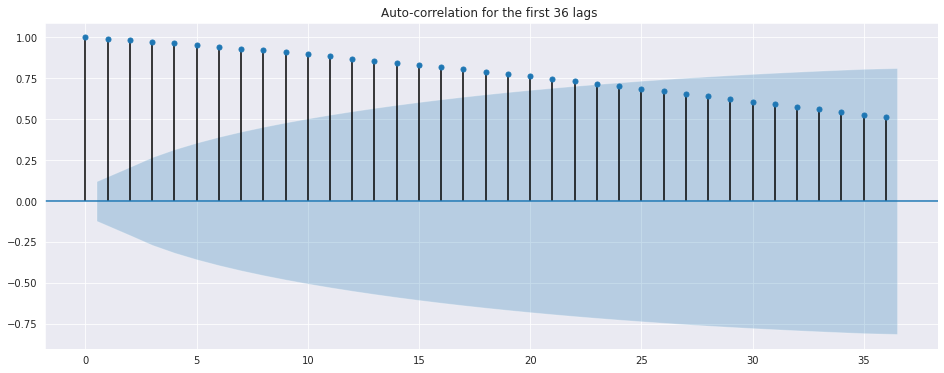

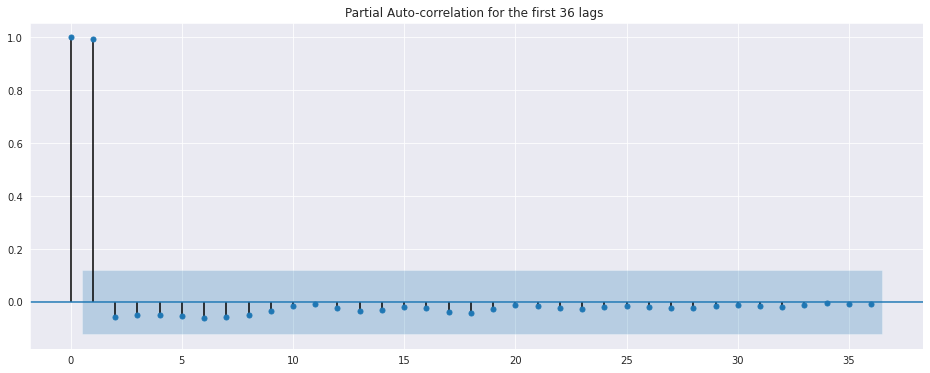

*** Ljung-Box Test [36 lags] ***
Q:  6206.401860763039
p-value:  0.0
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  260.318224281947
p-value:  8.469062156007633e-36
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [300]:
autocorrelationPlot(Hawaii_ts['Hawaii'], lags=36)
checkAutorcorrelation(Hawaii_ts['Hawaii'].values, lags=36)

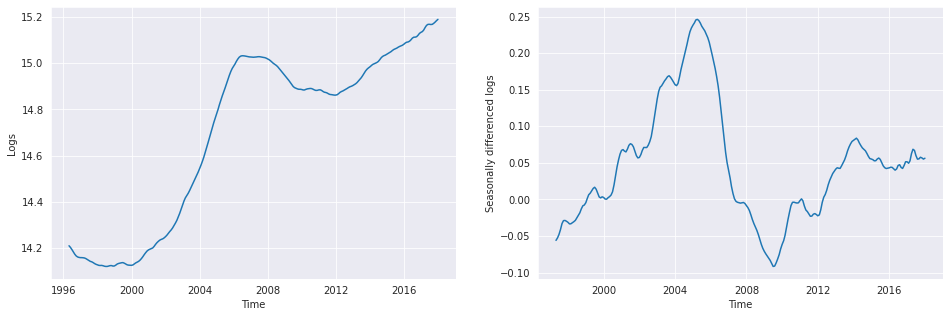

In [301]:
# Logarithm 
log_data = np.log(Hawaii_ts['Hawaii'])
fig, ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(log_data)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Logs');

# Seasonal differencing
Hawaii_ts_sd = log_data.diff(12)
Hawaii_ts_sd .dropna(inplace=True)
difference_s = Hawaii_ts_sd
ax[1].plot(difference_s)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Seasonally differenced logs');

In [302]:
checkStationarity(difference_s , kpss_type='c')

*** ADF Test ***
ADF Statistic:  -2.880138448688598
p-value:  0.047706854611963515
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.16983314204608674
p-value:  0.1
Interpretation: The time series is stationary (Ho)


In [305]:
checkStationarity(difference_s , kpss_type='ct')

*** ADF Test ***
ADF Statistic:  -2.880138448688598
p-value:  0.047706854611963515
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.15369603421056377
p-value:  0.04358663815786352
Interpretation: The time series is not trend stationary (Ha)


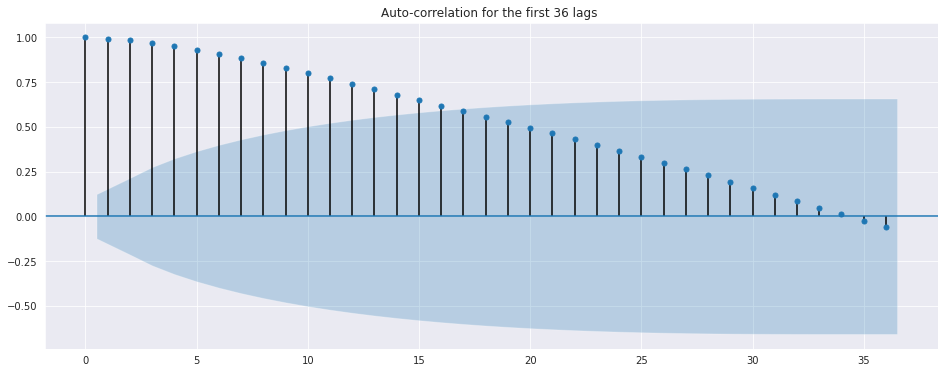

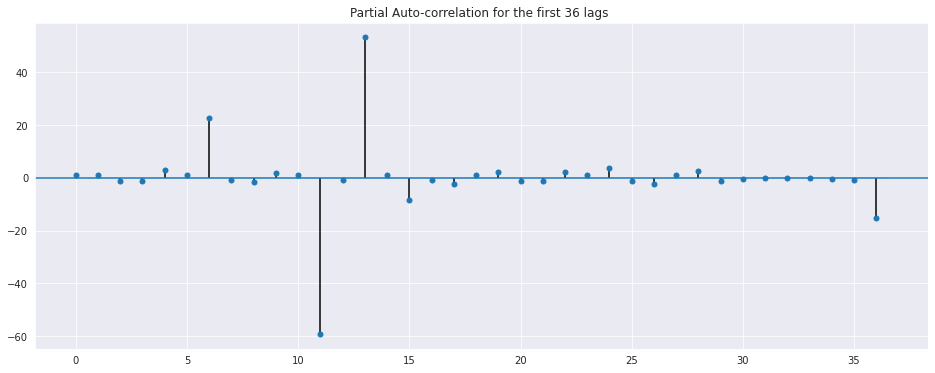

*** Ljung-Box Test [36 lags] ***
Q:  3541.503926714735
p-value:  0.0
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  246.44560700791644
p-value:  3.4636149182345334e-33
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [304]:

autocorrelationPlot(difference_s, lags=36)
checkAutorcorrelation(difference_s.values, lags=36)

#decomposition

In [308]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [321]:
#extracting components
sdecom = seasonal_decompose(log_data, model='additive', period=12, two_sided=True)

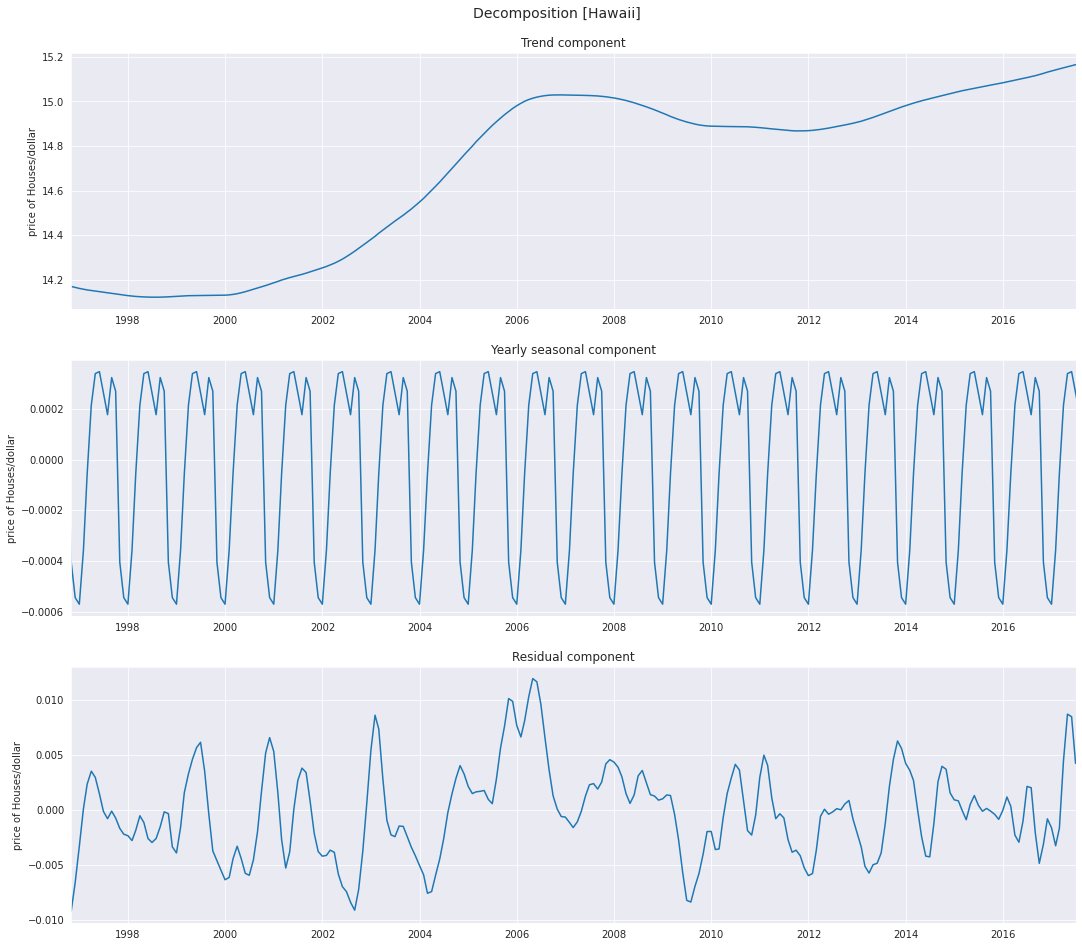

In [322]:
f, axes = plt.subplots(3,1,figsize=(18,16))
plt.suptitle('Decomposition [Hawaii]', y=0.92, fontsize=14)

#plotting trend component
axes[0].plot(sdecom.trend)
axes[0].set_title('Trend component', fontdict={'fontsize': 12})

#plotting yearly seasonal component
axes[1].plot(sdecom.seasonal)
axes[1].set_title('Yearly seasonal component', fontdict={'fontsize': 12})

#plotting residual of decomposition
axes[2].plot(sdecom.resid)
axes[2].set_title('Residual component', fontdict={'fontsize': 12})

for a in axes:
    a.set_ylabel('price of Houses/dollar')
    a.set_xlim(sdecom.trend.dropna().index[0], sdecom.trend.dropna().index[-1])

#showing chart
plt.show()

#decomposition-residual

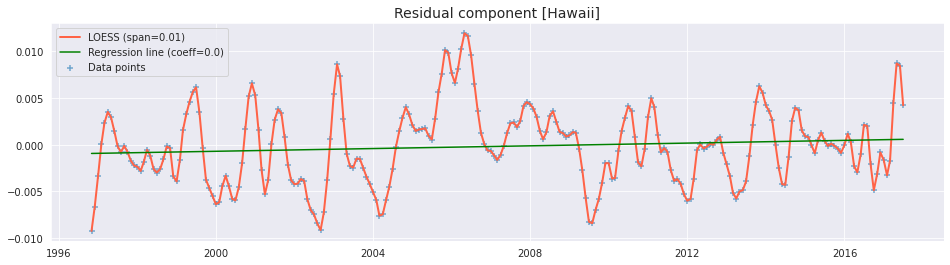

In [323]:
decomp_residuals = pd.DataFrame(sdecom.resid.dropna())
plotTS(decomp_residuals, column='resid', figsize=(16,4), title='Residual component [Hawaii]')

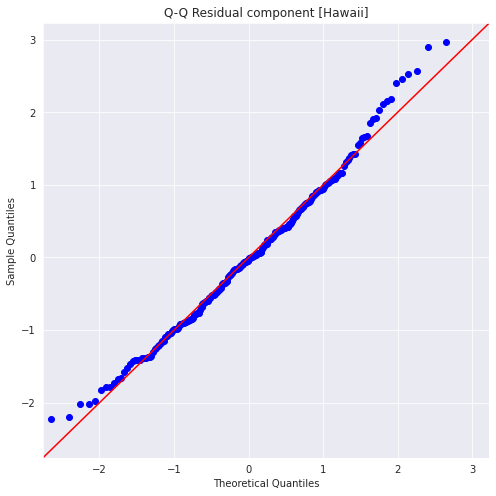

*** Shapiro-Wilk Test ***
W:  0.9896329045295715
p-value:  0.07207722216844559
Interpretation: the data was drawn from a normal distribution (Ho)

*** Jarque-Bera Test ***
Jarque-Bera JB:  4.796924705009937
p-value:  0.09085755282297359
Interpretation: the data was drawn from a normal distribution (Ho)

*** D’Agostino-Pearson Test ***
k2:  [4.95245455]
p-value:  [0.08405976]
Interpretation: the data was drawn from a normal distribution (Ho)

----------------------------------------------------------------------
Skewness:  [0.33882393]
Kurtosis :  [0.05610318]


In [324]:
qqPlot(decomp_residuals['resid'], title='Residual component [Hawaii]')
checkNormality(decomp_residuals)

In [325]:
checkStationarity(decomp_residuals, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -3.582224309528182
p-value:  0.006110096725468346
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.14144828525806505
p-value:  0.1
Interpretation: The time series is stationary (Ho)


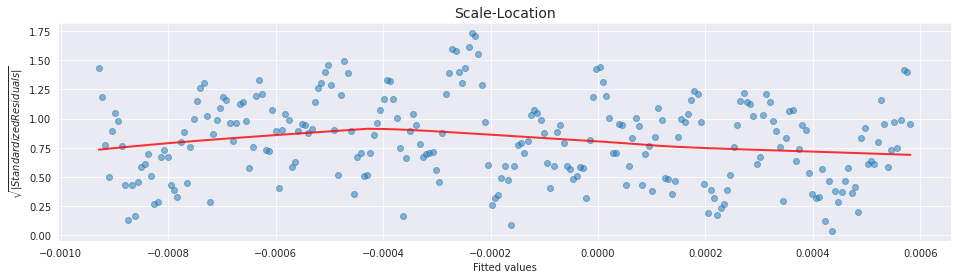

*** Koenker Test ***
Lagrange multiplier statistic:  2.1460389641184427
p-value:  0.1429382419042395
Interpretation: Homoscedasticity is present, the residuals are distributed with equal variance (Ho)


In [326]:
scalelocationPlot(decomp_residuals['resid'], figsize=(16,4))
checkHomoscedasticity(decomp_residuals, robust=True)

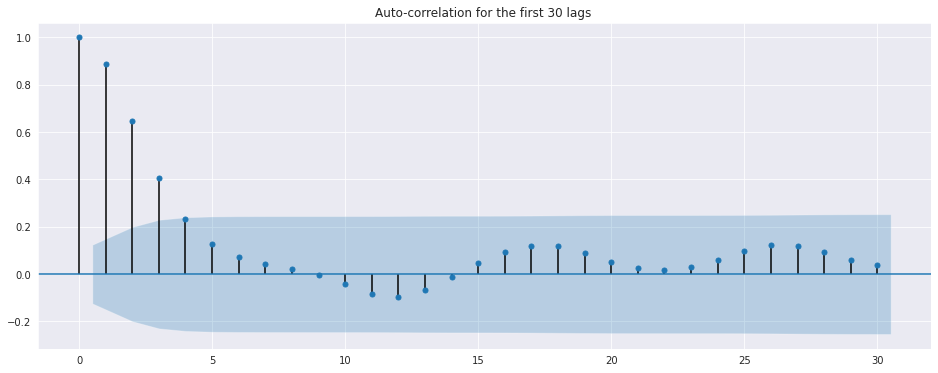

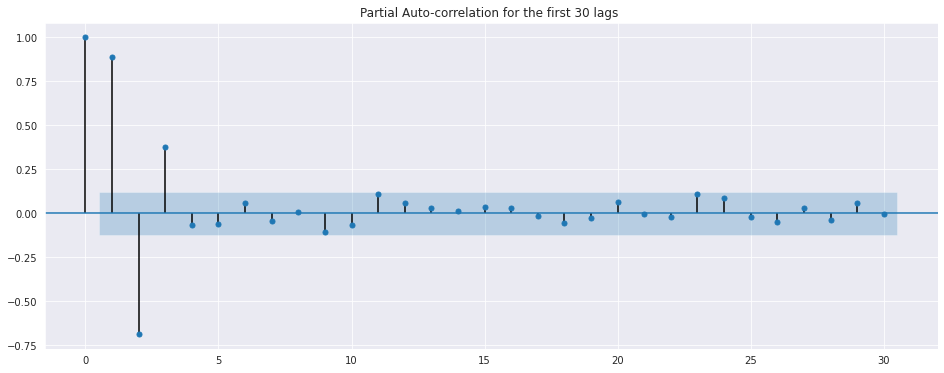

*** Ljung-Box Test [30 lags] ***
Q:  401.5742508195145
p-value:  1.3439087302565068e-66
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [30 lags] ***
Lagrange multiplier statistic:  225.1810129469948
p-value:  8.714377050080782e-32
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [327]:
autocorrelationPlot(decomp_residuals['resid'], lags=30)
checkAutorcorrelation(decomp_residuals, lags=30)

#**Models**

In [328]:
# Train and test 
data_train = Hawaii_ts[:-24]['Hawaii'] 
data_test = Hawaii_ts[-24:]['Hawaii']

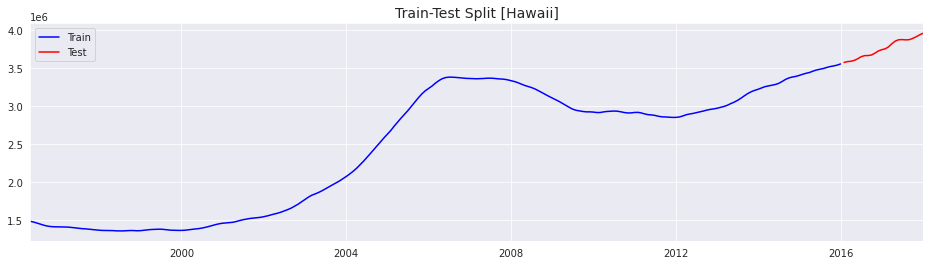

In [329]:
plt.figure(figsize=(16,4))
plt.plot(data_train, color='blue', label='Train')
plt.plot(data_test, color='red', label='Test')
plt.xlim(data_train.index[0],data_test.index[-1])
plt.title('Train-Test Split [Hawaii]', fontsize=14)
plt.legend()
plt.show()

#ARIMA

In [318]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [319]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AICC=5314.873, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AICC=5312.055, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AICC=inf, Time=nan sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AICC=5312.010, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AICC=5357.663, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AICC=5311.202, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AICC=5312.041, Time=0.21 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AICC=5314.087, Time=1.62 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AICC=5305.580, Time=1.14 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AICC=inf, Time=nan sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AICC=5787.527, Time=1.76 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AICC=inf, Time=1.72 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AICC=5311.118, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AICC=10173.526, Time=0.71 sec
 ARIMA(1,1,2)(0,0,0)

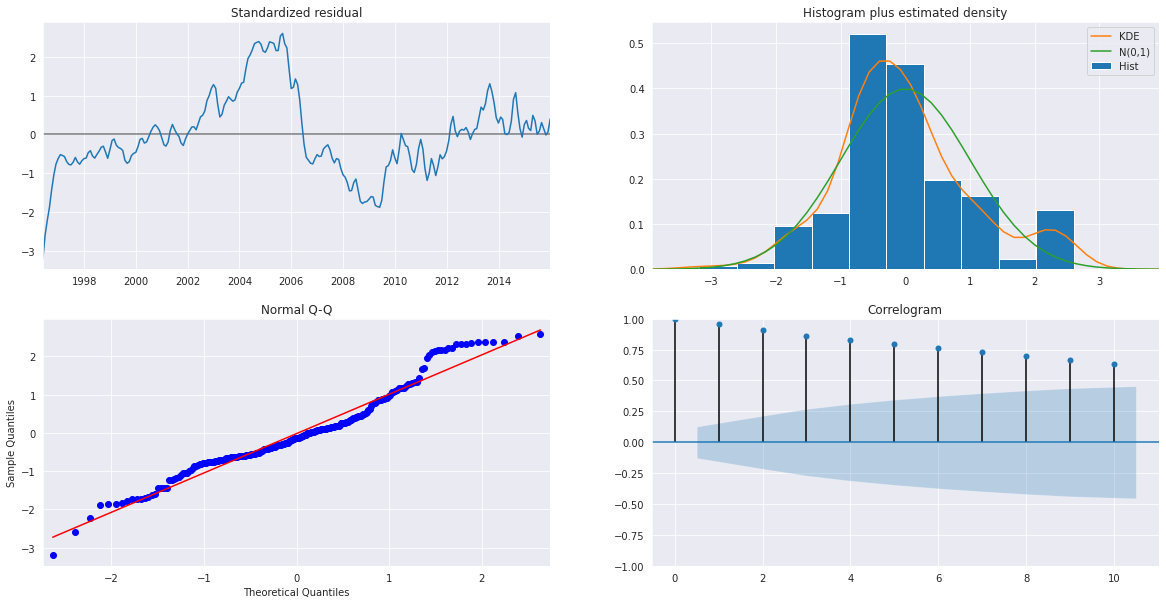

In [330]:
# Auto-ARIMA 

arima_model =  auto_arima(data_train,start_p=0 , start_q=0, 
                          max_p=7, max_d=2, max_q=7, # maximum p d q
                          seasonal=True,   # Seasonality
                          m=12,              # Seasonality type (Yearly)
                          max_P=7, max_D=2, max_Q=7, # maximum P D Q
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,information_criterion='aicc')
print(arima_model.summary())
arima_model.plot_diagnostics(figsize=(20, 10));

                               SARIMAX Results                                
Dep. Variable:                 Hawaii   No. Observations:                  237
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2237.727
Date:                Wed, 08 Feb 2023   AIC                           4483.455
Time:                        18:25:02   BIC                           4497.276
Sample:                    04-30-1996   HQIC                          4489.027
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    285.2856    300.997      0.948      0.343    -304.659     875.230
ar.L1          0.9779      0.014     71.866      0.000       0.951       1.005
ma.L1          0.1034      0.010     10.285      0.0

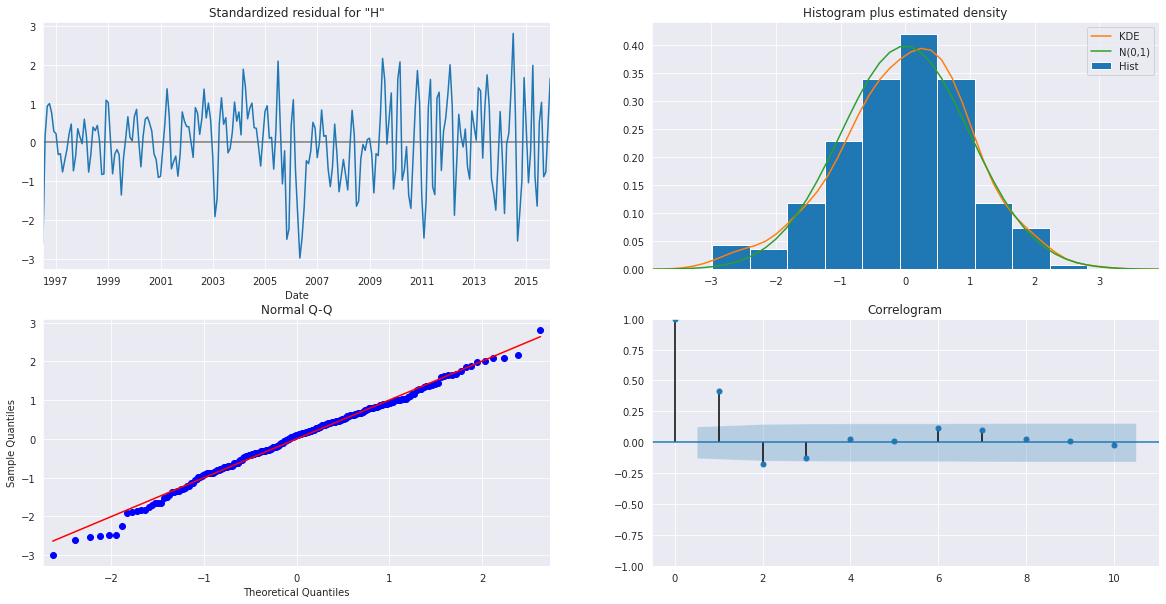

In [331]:
# Fit the model with the automatically selected parameters - ARIMA(1,1,0)(0,1,0)[12]
[p,d,q] = [1,1,1] # stepwise_model.order
[P,D,Q,S] = [0,0,0,12] # stepwise_model.seasonal_order
model_ARIMA_auto = SARIMAX(data_train, 
                       order=(p,d,q), 
                       seasonal_order=(P,D,Q,S), 
                       enforce_stationarity=False,
                       enforce_invertibility=False, trend='c') # Auto-ARIMA idenfied a model with intercept as optimal, thus we include trend here 
result_ARIMA_auto = model_ARIMA_auto.fit()

# Verify the residuals
print(result_ARIMA_auto.summary()) 
result_ARIMA_auto.plot_diagnostics(figsize=(20, 10));

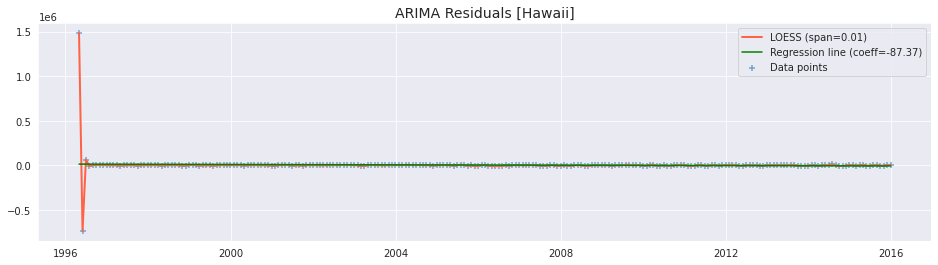

In [332]:
arima_resid = pd.Series(result_ARIMA_auto.resid, index =data_train.index)
plotTS(pd.DataFrame(arima_resid, columns=['resid']), column='resid', figsize=(16,4), title='ARIMA Residuals [Hawaii]')

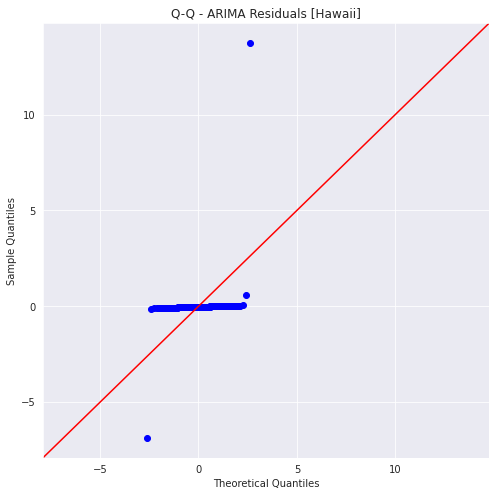

*** Shapiro-Wilk Test ***
W:  0.08918631076812744
p-value:  3.880793212852024e-32
Interpretation: the data was not drawn from a normal distribution (Ha)

*** Jarque-Bera Test ***
Jarque-Bera JB:  247328.14724582576
p-value:  0.0
Interpretation: the data was not drawn from a normal distribution (Ha)

*** D’Agostino-Pearson Test ***
k2:  429.85655417181454
p-value:  4.548154996865321e-94
Interpretation: the data was not drawn from a normal distribution (Ha)

----------------------------------------------------------------------
Skewness:  9.592615367867081
Kurtosis :  157.09174150892795


In [333]:
qqPlot(arima_resid, title='- ARIMA Residuals [Hawaii]')
checkNormality(arima_resid)

In [334]:
checkStationarity(arima_resid, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -5.240391364346942
p-value:  7.267486940041408e-06
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.2928041589452749
p-value:  0.1
Interpretation: The time series is stationary (Ho)


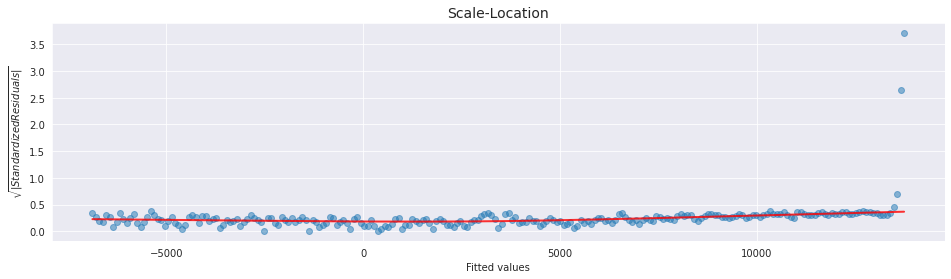

*** Koenker Test ***
Lagrange multiplier statistic:  4.461041544728642
p-value:  0.034676347762482046
Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)


In [335]:
scalelocationPlot(arima_resid, figsize=(16,4))
checkHomoscedasticity(arima_resid, robust=True)

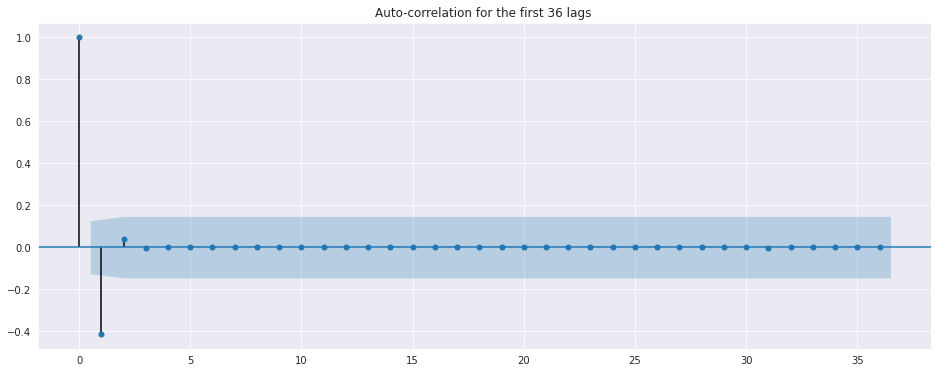

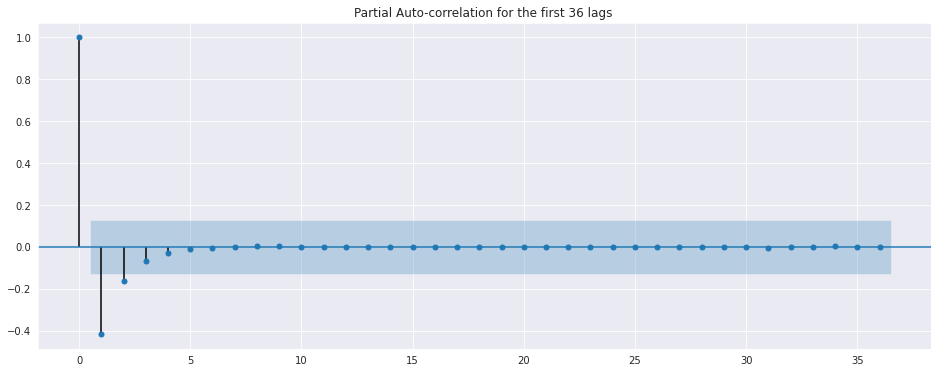

*** Ljung-Box Test [36 lags] ***
Q:  41.484659142852934
p-value:  0.24386928523741305
Interpretation: the residuals are independently distributed (Ho)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  46.553151973366994
p-value:  0.11191644393568559
Interpretation: there is no autocorrelation at any order less than or equal to p (Ho)


In [336]:
autocorrelationPlot(arima_resid, lags=36)
checkAutorcorrelation(arima_resid, lags=36)

In [337]:
y_pred_arima = arima_model.predict(n_periods=24)
y_pred_arima = pd.Series(y_pred_arima)
y_pred_arima.index = data_test.index

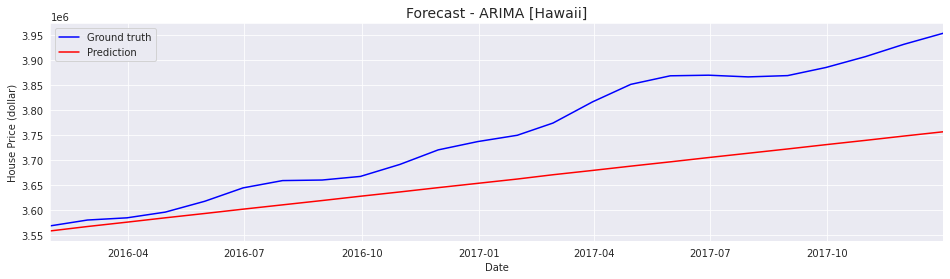

In [338]:
plt.figure(figsize=(16,4))
plt.plot(data_test, color='blue', label='Ground truth')
plt.plot(y_pred_arima, color='red', label='Prediction')
plt.title('Forecast - ARIMA [Hawaii]', fontsize=14)
plt.xlim(data_test.index[0],data_test.index[-1])
plt.xlabel('Date')
plt.ylabel('House Price (dollar)')
plt.legend()
plt.show()

In [339]:
mse_arima = mean_squared_error(y_pred_arima,data_test.values)
mae_arima = mean_absolute_error(y_pred_arima,data_test.values)
mape_arima = mean_absolute_percentage_error(y_pred_arima,data_test.values)*100

print('ARIMA model performance: ')
print('MSE: ', round(mse_arima,3))
print('MAE: ', round(mae_arima,3))
print('MAPE: ', round(mape_arima,3), '%')

ARIMA model performance: 
MSE:  13052313001.723
MAE:  95030.001
MAPE:  2.571 %


#Prophet

In [340]:
from prophet import Prophet

In [341]:
train_prophet = pd.DataFrame({'y':data_train.values,'ds':data_train.index.to_list()})
prophet_model = Prophet(daily_seasonality=False, weekly_seasonality=False,yearly_seasonality=True)
prophet_fitted_model = prophet_model.fit(train_prophet)
future = prophet_fitted_model.make_future_dataframe(periods = 24)
forecast = prophet_fitted_model.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpjrrdqnuy/xdfwr_9t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjrrdqnuy/rmvd2oxy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54796', 'data', 'file=/tmp/tmpjrrdqnuy/xdfwr_9t.json', 'init=/tmp/tmpjrrdqnuy/rmvd2oxy.json', 'output', 'file=/tmp/tmpjrrdqnuy/prophet_modele4j7ua12/prophet_model-20230208182602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


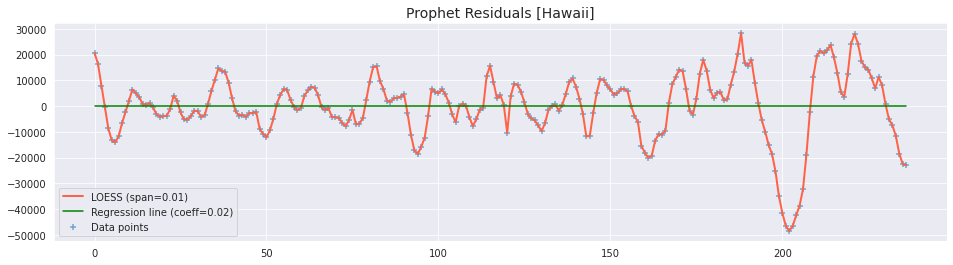

In [342]:
tmp = pd.merge(train_prophet, forecast.head(len(forecast)-24), on='ds')
prophet_resid = tmp['y'] - tmp['yhat']
plotTS(pd.DataFrame(prophet_resid, columns=['resid']), column='resid', figsize=(16,4), title='Prophet Residuals [Hawaii]')

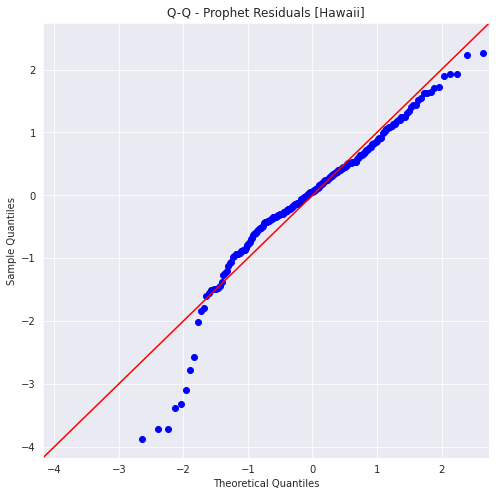

*** Shapiro-Wilk Test ***
W:  0.9338152408599854
p-value:  7.658867318127704e-09
Interpretation: the data was not drawn from a normal distribution (Ha)

*** Jarque-Bera Test ***
Jarque-Bera JB:  115.40707971234718
p-value:  0.0
Interpretation: the data was not drawn from a normal distribution (Ha)

*** D’Agostino-Pearson Test ***
k2:  52.472935946744286
p-value:  4.03317191700474e-12
Interpretation: the data was not drawn from a normal distribution (Ha)

----------------------------------------------------------------------
Skewness:  -1.0519142869170848
Kurtosis :  2.6945682797401656


In [343]:
qqPlot(prophet_resid, title='- Prophet Residuals [Hawaii]')
checkNormality(prophet_resid)

In [344]:
checkStationarity(prophet_resid, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -5.287822347355221
p-value:  5.8028182103944585e-06
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.02245320831810333
p-value:  0.1
Interpretation: The time series is stationary (Ho)


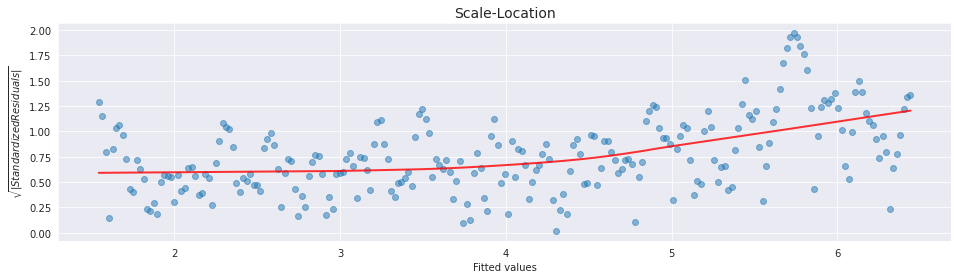

*** Koenker Test ***
Lagrange multiplier statistic:  34.466333397710756
p-value:  4.336881329587007e-09
Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)


In [345]:
scalelocationPlot(prophet_resid, figsize=(16,4))
checkHomoscedasticity(prophet_resid, robust=True)

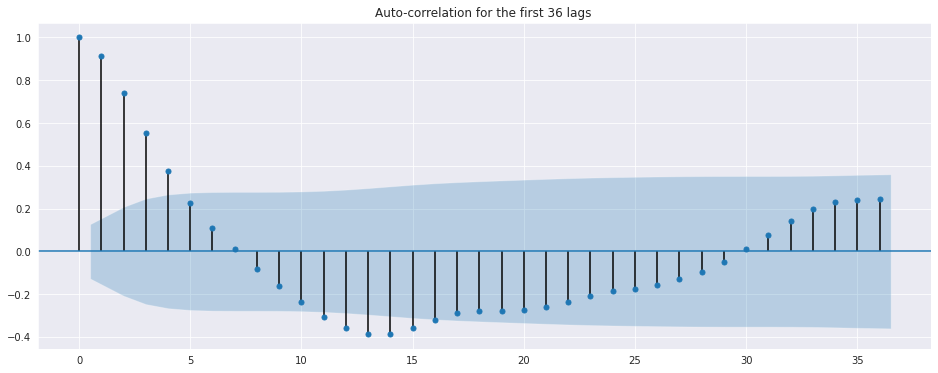

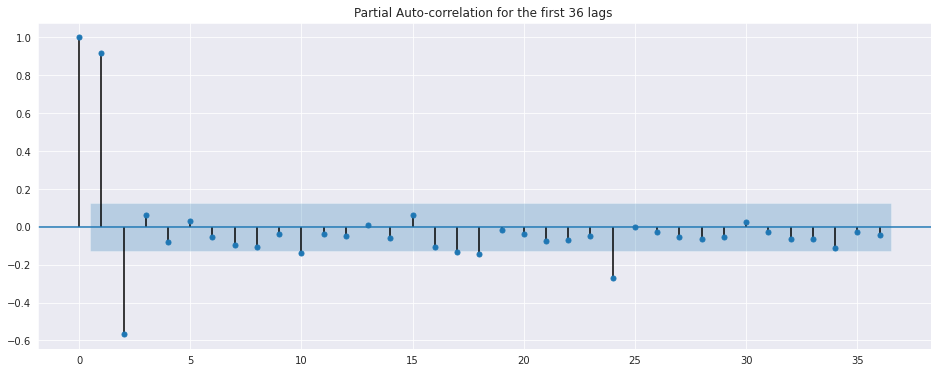

*** Ljung-Box Test [36 lags] ***
Q:  890.4468655626191
p-value:  1.3600196040441893e-163
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  217.0847860682138
p-value:  9.724732359096311e-28
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [346]:
autocorrelationPlot(prophet_resid, lags=36)
checkAutorcorrelation(prophet_resid, lags=36)

In [347]:
y_pred_prophet = forecast['yhat'].tail(24)
y_pred_prophet.index = data_test.index

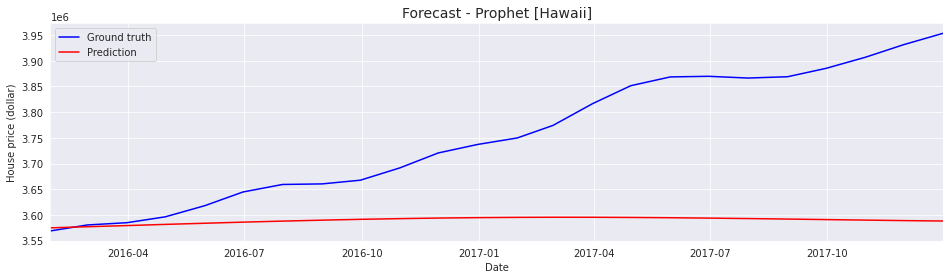

In [348]:
plt.figure(figsize=(16,4))
plt.plot(data_test, color='blue', label='Ground truth')
plt.plot(y_pred_prophet, color='red', label='Prediction')
plt.title('Forecast - Prophet [Hawaii]', fontsize=14)
plt.xlim(data_test.index[0],data_test.index[-1])
plt.xlabel('Date')
plt.ylabel('House price (dollar)')
plt.legend()
plt.show()

In [349]:
mse_prophet = mean_squared_error(y_pred_prophet,data_test.values)
mae_prophet = mean_absolute_error(y_pred_prophet,data_test.values)
mape_prophet = mean_absolute_percentage_error(y_pred_prophet,data_test.values)*100

print('Prophet model performance: ')
print('MSE: ', round(mse_prophet,3))
print('MAE: ', round(mae_prophet,3))
print('MAPE: ', round(mape_prophet,3), '%')

Prophet model performance: 
MSE:  40747596672.544
MAE:  164121.324
MAPE:  4.569 %


# Triple Exponential Smoothing (Holt-Winters method)

In [350]:
# Triple Exponential Smoothing (Holt-Winters method)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [351]:
# Fit = multiplicative trend, additive seasonal of period season_length = 36
holtwinters_fitted_model = ExponentialSmoothing(data_train,seasonal_periods=36,trend='mul',seasonal='add').fit()

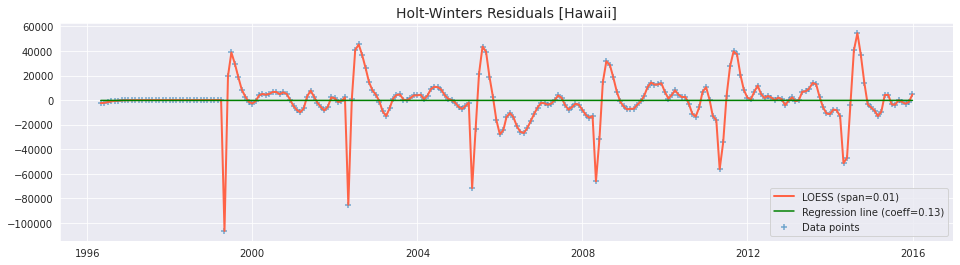

In [352]:
holtwinters_resid = pd.Series(holtwinters_fitted_model.resid, index =data_train.index)
plotTS(pd.DataFrame(holtwinters_resid, columns=['resid']), column='resid', figsize=(16,4), title='Holt-Winters Residuals [Hawaii]')

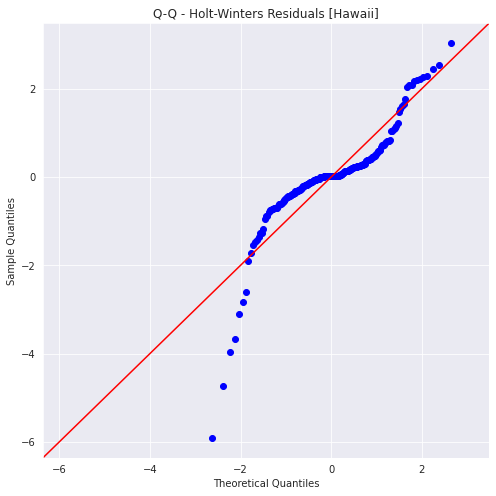

*** Shapiro-Wilk Test ***
W:  0.8054792881011963
p-value:  1.6799462523245655e-16
Interpretation: the data was not drawn from a normal distribution (Ha)

*** Jarque-Bera Test ***
Jarque-Bera JB:  855.6770024458066
p-value:  0.0
Interpretation: the data was not drawn from a normal distribution (Ha)

*** D’Agostino-Pearson Test ***
k2:  103.97406897001676
p-value:  2.644343033302363e-23
Interpretation: the data was not drawn from a normal distribution (Ha)

----------------------------------------------------------------------
Skewness:  -1.5002454864184243
Kurtosis :  8.811803993090132


In [353]:
qqPlot(holtwinters_resid, title='- Holt-Winters Residuals [Hawaii]')
checkNormality(holtwinters_resid)

In [354]:
checkStationarity(holtwinters_resid, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -8.589285664077957
p-value:  7.360716769749804e-14
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.08071421915199728
p-value:  0.1
Interpretation: The time series is stationary (Ho)


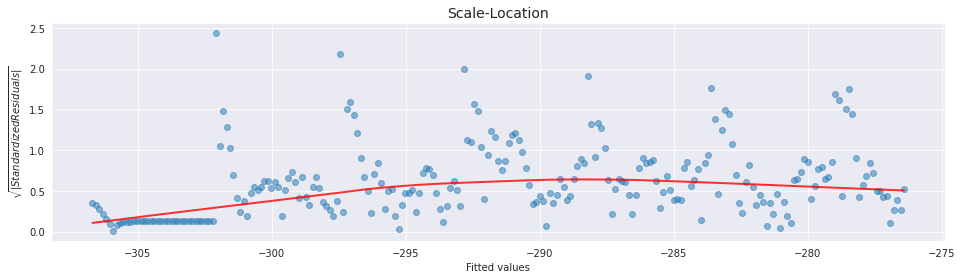

*** Koenker Test ***
Lagrange multiplier statistic:  0.05096846316113468
p-value:  0.8213865637695577
Interpretation: Homoscedasticity is present, the residuals are distributed with equal variance (Ho)


In [355]:
scalelocationPlot(holtwinters_resid, figsize=(16,4))
checkHomoscedasticity(holtwinters_resid, robust=True)

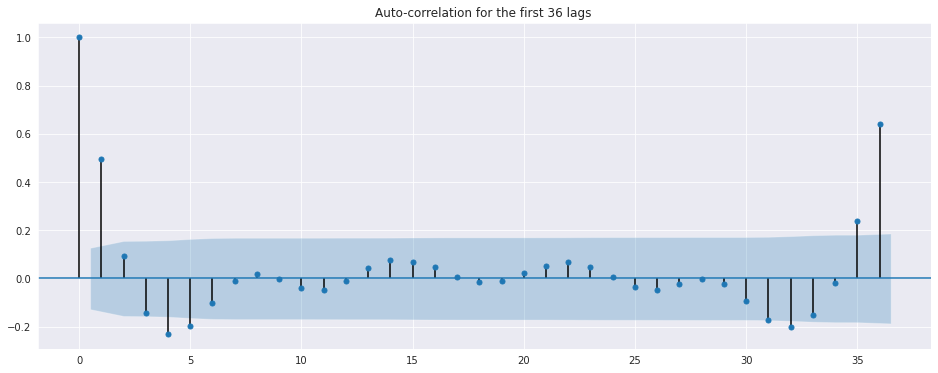

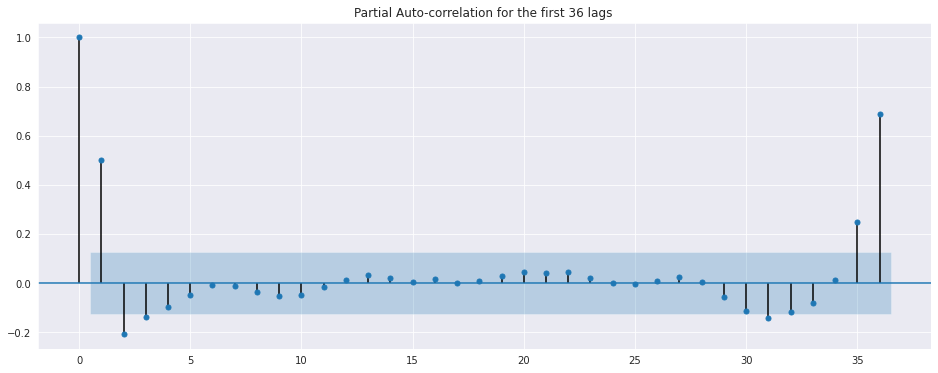

*** Ljung-Box Test [36 lags] ***
Q:  261.0412237867308
p-value:  6.182124638976311e-36
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  146.8365566321982
p-value:  2.4809585245628774e-15
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [356]:
autocorrelationPlot(holtwinters_resid, lags=36)
checkAutorcorrelation(holtwinters_resid, lags=36)

In [357]:
# Predictions
y_pred_holtwinters = holtwinters_fitted_model.forecast(24)
y_pred_holtwinters = pd.Series(y_pred_holtwinters, index=data_test.index)

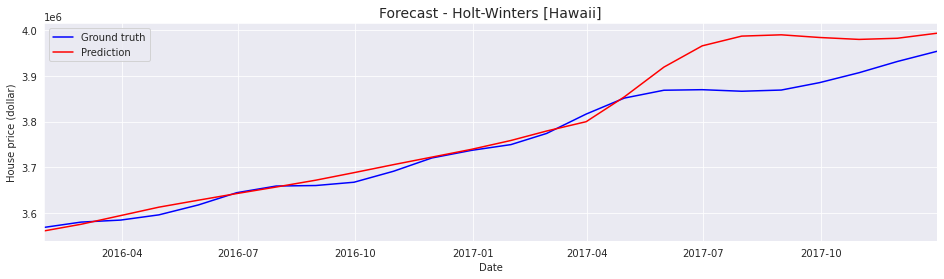

In [358]:
plt.figure(figsize=(16,4))
plt.plot(data_test, color='blue', label='Ground truth')
plt.plot(y_pred_holtwinters, color='red', label='Prediction')
plt.title('Forecast - Holt-Winters [Hawaii]', fontsize=14)
plt.xlim(data_test.index[0],data_test.index[-1])
plt.xlabel('Date')
plt.ylabel('House price (dollar)')
plt.legend()
plt.show()

In [359]:
mse_holtwinters = mean_squared_error(y_pred_holtwinters,data_test.values)
mae_holtwinters = mean_absolute_error(y_pred_holtwinters,data_test.values)
mape_holtwinters = mean_absolute_percentage_error(y_pred_holtwinters,data_test.values)*100

print('Holt-Winters model performance: ')
print('MSE: ', round(mse_holtwinters,3))
print('MAE: ', round(mae_holtwinters,3))
print('MAPE: ', round(mape_holtwinters,3), '%')

Holt-Winters model performance: 
MSE:  2572051109.535
MAE:  32805.513
MAPE:  0.836 %


#Summery

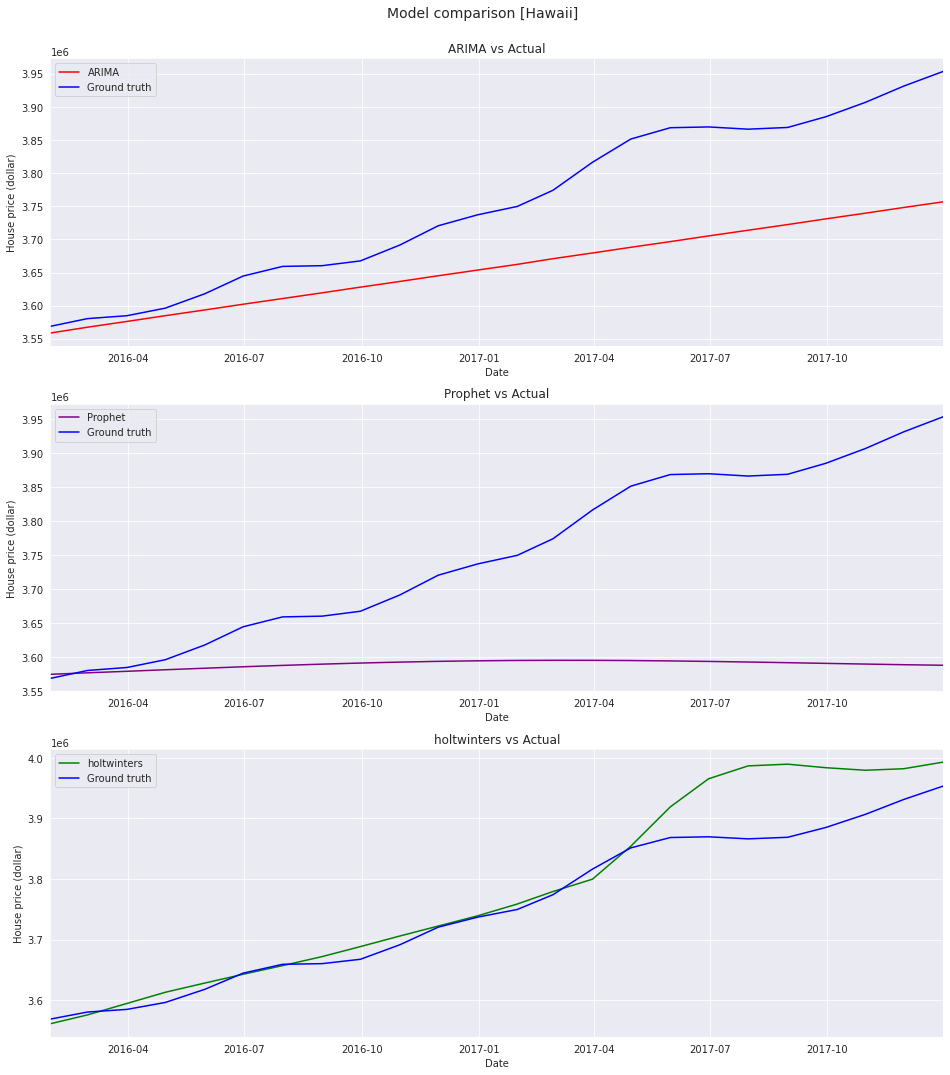

In [360]:
f, axes = plt.subplots(3,1,figsize=(16,18))
plt.suptitle('Model comparison [Hawaii]', y=0.92, fontsize=14)

axes[0].plot(y_pred_arima, color='red', label='ARIMA')
axes[0].plot(data_test, color='blue', label='Ground truth')
axes[0].set_title('ARIMA vs Actual', fontdict={'fontsize': 12})

axes[1].plot(y_pred_prophet, color='purple', label='Prophet')
axes[1].plot(data_test, color='blue', label='Ground truth')
axes[1].set_title('Prophet vs Actual', fontdict={'fontsize': 12})

axes[2].plot(y_pred_holtwinters, color='green', label='holtwinters')
axes[2].plot(data_test, color='blue', label='Ground truth')
axes[2].set_title('holtwinters vs Actual', fontdict={'fontsize': 12})

for a in axes:
    a.set_ylabel('House price (dollar)')
    a.set_xlabel('Date')
    a.set_xlim(data_test.index[0], data_test.index[-1])
    a.legend()

plt.show()

In [361]:
data = {'Model':['ARIMA','PROPHET','HOLT WINTERS'],
        'MSE':[mse_arima, mse_prophet, mse_holtwinters],
        'MAE':[mae_arima, mae_prophet, mae_holtwinters],
        'MAPE (%)':[mape_arima, mape_prophet, mape_holtwinters],
        'Stationarity (residuals)':['Stationary','Stationary','Stationary'],
        'Distribution (residuals)':['Not normal','Not normal','Not normal'],
        'Homoscedasticity (residuals)':['Homoscedastic','Heteroscedastic','Heteroscedastic'],
        'Autocorrelation (residuals)':['Autocorrelated','Autocorrelated','Autocorrelated']}

all_models_summary = pd.DataFrame(data)
display(round(all_models_summary,3))

,Model,MSE,MAE,MAPE (%),Stationarity (residuals),Distribution (residuals),Homoscedasticity (residuals),Autocorrelation (residuals)
0,ARIMA,1.305231e+10,95030.001,2.571,Stationary,Not normal,Homoscedastic,Autocorrelated
1,PROPHET,4.074760e+10,164121.324,4.569,Stationary,Not normal,Heteroscedastic,Autocorrelated
2,HOLT WINTERS,2.572051e+09,32805.513,0.836,Stationary,Not normal,Heteroscedastic,Autocorrelated


#Forcasting